In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from functools import reduce
from scipy import stats
import statsmodels.api as sm
from sklearn.preprocessing import PowerTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
plt.style.use('fivethirtyeight')

In [2]:
# Read all csv files into dataframes
vertical = pd.read_csv(r"C:\Users\sychev.6\Downloads\DA_Take_Home_Assignment\data\data_vertical.csv")
segment = pd.read_csv(r"C:\Users\sychev.6\Downloads\DA_Take_Home_Assignment\data\data_business_segments.csv")
level = pd.read_csv(r"C:\Users\sychev.6\Downloads\DA_Take_Home_Assignment\data\data_integrations.csv")
country = pd.read_csv(r"C:\Users\sychev.6\Downloads\DA_Take_Home_Assignment\data\data_countries.csv")
orders = pd.read_csv(r"C:\Users\sychev.6\Downloads\DA_Take_Home_Assignment\data\data_orders.csv")
operations = pd.read_csv(r"C:\Users\sychev.6\Downloads\DA_Take_Home_Assignment\data\data_operations.csv")
finance = pd.read_csv(r"C:\Users\sychev.6\Downloads\DA_Take_Home_Assignment\data\data_finance.csv")

**First step** is to merge all dataframes with metrics and group by partner id to get total result of observed week and necessary structure one row per each partner.

In [3]:
# Checking size of dataframes for the merging purposes
orders.shape[0] == operations.shape[0] == finance.shape[0]

True

In [4]:
# Compile the list of dataframes with metrics to merge
data_frames = [orders, operations, finance]

# Merge all dataframes in the list together on partner_id and date
metrics = reduce(lambda  left,right: pd.merge(left, right, on=['date','partner_id'], how='outer'), data_frames)

In [5]:
# Custom function to calculate weighted average for delivery_time, preparation_time, order_cost and order_revenue
wm = lambda x: np.average(x, weights=metrics.loc[x.index, "orders_daily"])

# Group and aggregate combined dataset 
metrics_grouped = metrics.groupby(['partner_id'], as_index=False).agg({'orders_daily':'sum', 
                                                                       'connected_hours':'sum', 
                                                                       'avg_delivery_time_min':wm, 
                                                                       'avg_preparation_time_min':wm,
                                                                       'avg_order_cost':wm,
                                                                       'avg_order_revenue':wm
                                                                        }).rename(columns={'orders_daily':'orders_weekly'})
# Briefly review of grouped dataframe
metrics_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46208 entries, 0 to 46207
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   partner_id                46208 non-null  int64  
 1   orders_weekly             46208 non-null  float64
 2   connected_hours           46208 non-null  int64  
 3   avg_delivery_time_min     46208 non-null  float64
 4   avg_preparation_time_min  46208 non-null  float64
 5   avg_order_cost            46208 non-null  float64
 6   avg_order_revenue         46208 non-null  float64
dtypes: float64(5), int64(2)
memory usage: 2.8 MB


In [6]:
# Checking size of dataframes for the merging purposes
vertical.shape[0] == segment.shape[0] == level.shape[0] == country.shape[0] == metrics_grouped.shape[0]

True

**Second step** is to join all dimesions and metrics together to end up with dataset containing one row per partner with all the dimensions and metrics as columns.

In [7]:
# Compile the dimension dataframes with metrics
dfs = [vertical, segment, level, country, metrics_grouped]

# Merge all dataframes in the list together on partner_id
partners = reduce(lambda  left,right: pd.merge(left, right, on=['partner_id'], how='outer'), dfs)

# First 5 rows of dataset
print(partners.head())
print('-'*100,'\n')

# Null values, dtypes, entries per column
print(partners.info())
print('-'*100,'\n')

# Summary statistic
print(partners.describe())
print('-'*100,'\n')

# Check duplicated records
print("If any duplicates in dataset? Answer: {}".format(partners.duplicated().any()))

   partner_id vertical business_segment  is_integrated country  orders_weekly  \
0      169385     Food       Local Hero          False      ES            2.0   
1      230660     Food        Long Tail          False      PT           49.0   
2      247635     Food            Chain           True      ES           23.0   
3      341110     Food            Chain          False      ES           25.0   
4      368335     Food        Long Tail          False      ES           36.0   

   connected_hours  avg_delivery_time_min  avg_preparation_time_min  \
0               18              21.933333                 13.095000   
1                4              27.863265                  9.014281   
2                0              33.005072                 18.019130   
3               36              33.342000                 10.775067   
4               58              34.642130                 11.068542   

   avg_order_cost  avg_order_revenue  
0        5.985465          13.153395  
1       

**orders_weekly** logically contains whole numbers, can't include any decimal values. Should be converted to integers;

**is_integrated**: True represents integrated partners and False represents not integrated ones. Instead of keeping this format, let's replace it with "Yes" / "No".

In [8]:
partners['is_integrated'] = partners['is_integrated'].map({True: 'Yes', False: 'No'})
partners['orders_weekly'] = partners['orders_weekly'].astype('int64')
partners[['is_integrated','orders_weekly']].dtypes

is_integrated    object
orders_weekly     int64
dtype: object

Thus we have clean and well prepared dataset with no missing values or duplicated records and with correct structure of entries for further exploration and deriving insights.

#  **Task 1**

**1. How many active partners do we have in our dataset?**

Since all partner_ids are unique to answer the question simply caculate the number of all records in a dataset.

In [9]:
# Count nuber of unique values in 'partner_id' column
active_partners = partners['partner_id'].nunique()

# Print result
print("Number of active users in dataset: ",active_partners)

Number of active users in dataset:  46208


**2. What is the breakdown per country? And per business segment?**

To answer this question calculate number of records per each **country** and **business_segment** using *value_count* method and display results in real numbers and percentages.

In [10]:
# Count amount of each unique value in 'country' column in numbers and percentages and concat the result together
breakdown_per_country = pd.concat([partners["country"].value_counts(), 
                                   partners["country"].value_counts(normalize=True).mul(100).round(2)],axis=1, 
                                   keys=('Counts','Percentage'))

# Count amount of each unique value in 'business_segment' column in numbers and percentages and concat the result together
breakdown_per_segment = pd.concat([partners["business_segment"].value_counts(), 
                                   partners["business_segment"].value_counts(normalize=True).mul(100).round(2)],axis=1, 
                                   keys=('Counts','Percentage'))

# Print result
print("Breakdown per country:",'\n'*2,breakdown_per_country)
print('\n',"-"*30,'\n')
print("Breakdown per business segment:",'\n'*2,breakdown_per_segment)

Breakdown per country: 

     Counts  Percentage
ES   22183       48.01
IT   10840       23.46
UA    6808       14.73
PT    6377       13.80

 ------------------------------ 

Breakdown per business segment: 

             Counts  Percentage
Long Tail    21273       46.04
Chain         7529       16.29
Q-Commerce    7110       15.39
Local Hero    5475       11.85
Big Chain     3730        8.07
Sidekick      1089        2.36


Next stage is to get better understanding of all dimensions, for that let's perform vizulization technique to display counts and percentages for all of them.

In [11]:
# Select only dimensions
categorical = partners.select_dtypes(include=['object'])

# Function to perform univariate analysis
def UVA_category(data, var_group):
    
    '''
    Univariate_Analysis_categorical
    takes a group of variables (category) and plot/print all the value_counts and barplot.
    '''
    # Set figure_size
    size = len(var_group)
    plt.figure(figsize = (7*size,5), dpi = 100)

    # For every variable
    for j,i in enumerate(var_group):
        
        norm_count = data[i].value_counts(normalize = True).mul(100).round(2)
        n_uni = data[i].nunique()

        # Plot the variable with every information
        plt.subplot(1,size,j+1)
        sns.barplot(norm_count.index, norm_count, order = norm_count.index)
        plt.xlabel('fraction/percent', fontsize = 20)
        plt.xticks(rotation=45, fontsize=18)
        plt.ylabel('{}'.format(i), fontsize = 20)
        plt.title('n_uniques = {} \n Split in percentages (%)\n {};'.format(n_uni,norm_count.to_string(index=True)))

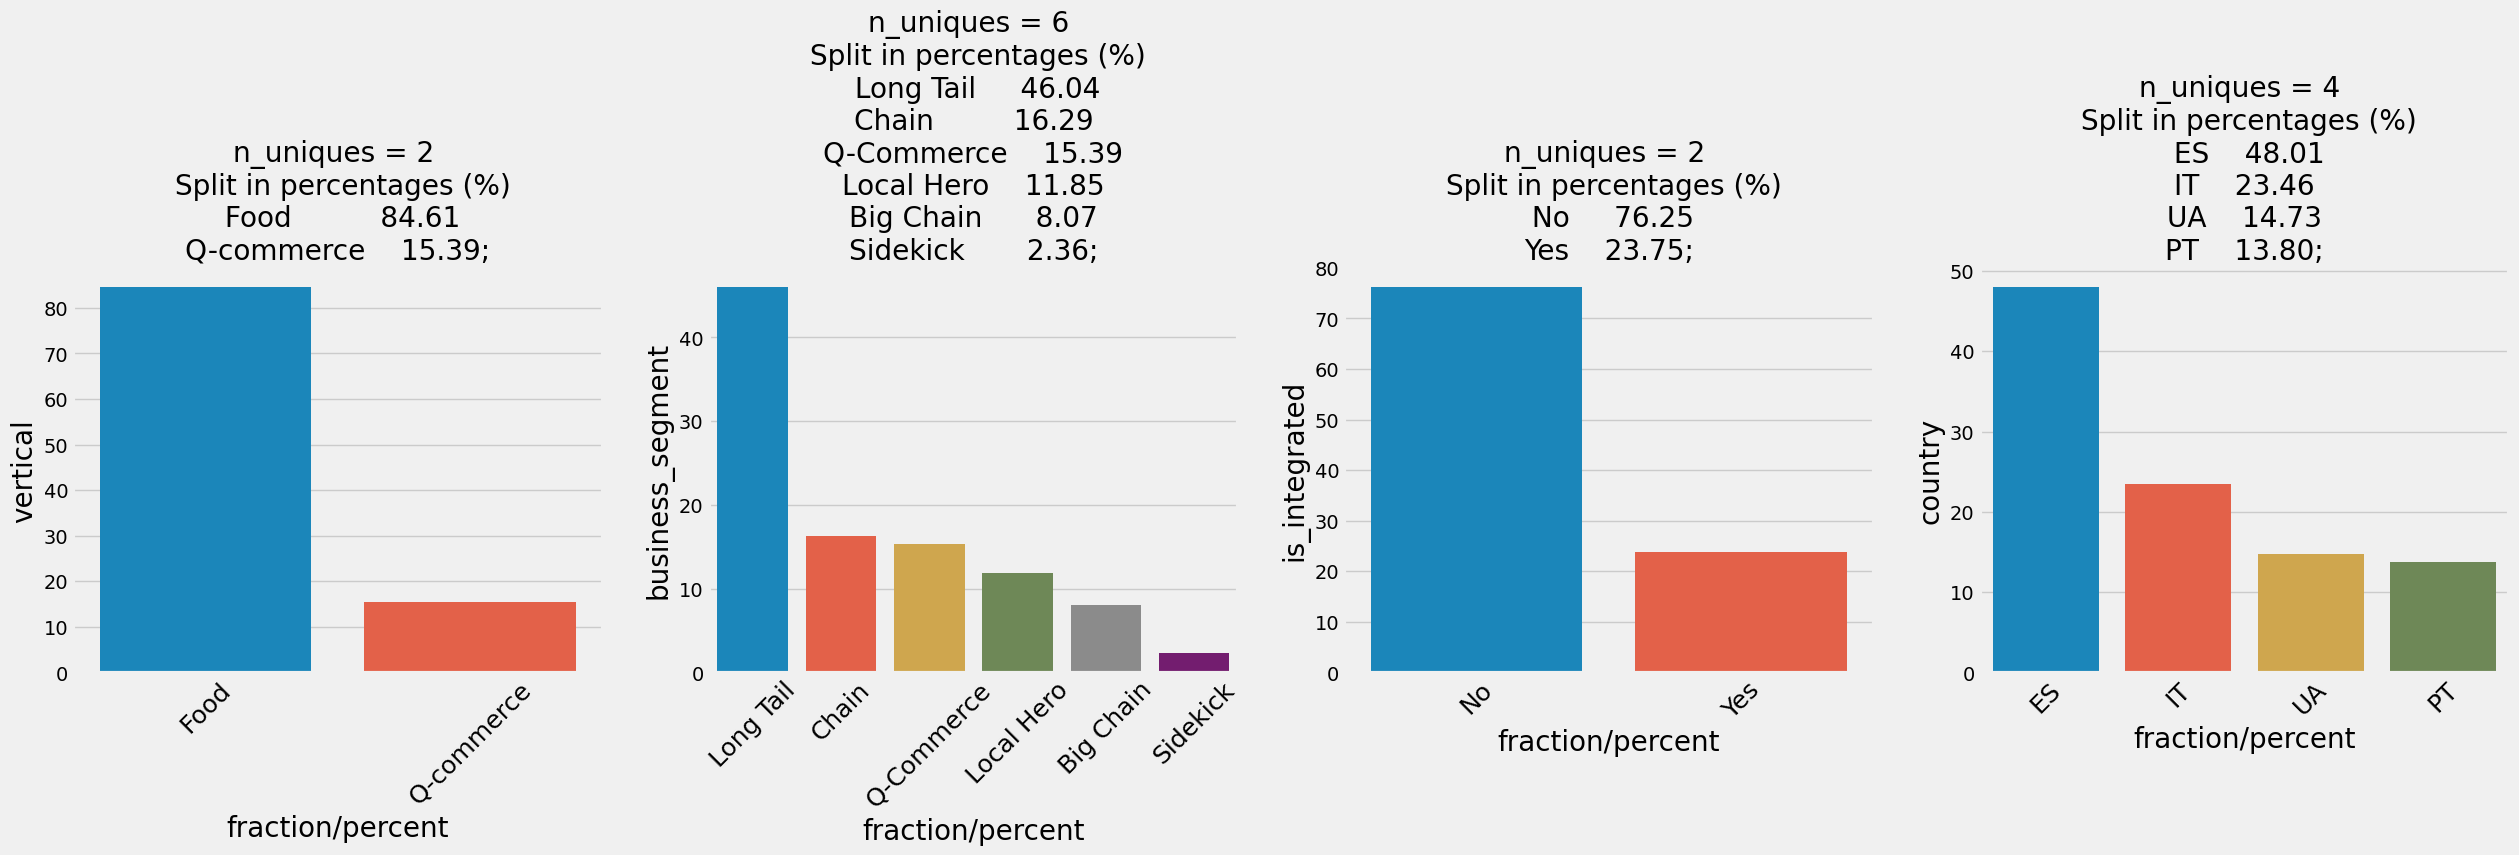

In [12]:
UVA_category(categorical, categorical.columns)

Inferences:

- overwhelming majority of all records belongs to **Food** *vertical* category;
- almost half partners are from **Long Tail** *business_segment*;
- only about quarter of all partners are **integrated**;
- around half records locate in **Spanish** market.

**3. What percentage of partners have delivered 80% of the orders?**

To find the answer follow such logic: 
 - calculate the sum of all orders;
 - define 80% threshold from the total amount;
 - sort orders descendingly to get biggest numbers on the top;
 - using 'cumsum' method go through the rows and keep indices of partners with biggest orders amount;
 - get number of partners with biggets orders by filtering with saved indices;
 - divide number of biggest partners by total amount of partners and multiply by 100 to get percentage

In [13]:
# Define threshold for filtering
thresh = 0.8 * partners['orders_weekly'].sum()

# Sort values descendingly for top orders
orders_weekly = partners['orders_weekly'].sort_values(ascending=False).reset_index(drop=True)

# Store indices of those with cumsum pass threshold
order_pass_thresh = orders_weekly.index[orders_weekly.cumsum().ge(thresh)]

# Get amount of partners with more orders than others
n_80_percentage = order_pass_thresh[0] + 1

# Print results
print("Percentage of partners have delivered 80% of the orders is", round(n_80_percentage/partners.shape[0]*100,2),"%")

Percentage of partners have delivered 80% of the orders is 21.37 %


This observation proofs well known **Pareto principle** that roughly 80% of consequences come from 20% of causes. 

**4. What is the average delivery time in Portugal (PT)?**

The solution can be gotten by selecting only subset with partners from Portugal and then calculating weighted average for 'avg_delivery_time_min' column with using number of orders as weights.

In [14]:
# Select only Portugues partners
portugal = partners[partners['country']=="PT"].copy()

# Calculate weighted average for 'avg_delivery_time_min' column
portugal_avg_delivery_time = np.average(portugal['avg_delivery_time_min'], 
                                        weights=portugal["orders_weekly"])
# Print result
print("Average delivery time in Portugal is {} min.".format(round(portugal_avg_delivery_time, 2)))

Average delivery time in Portugal is 34.98 min.


Let's visualize and compare Portugal result with the rest of markets.

In [15]:
# Function to plot average delivery time per country
def delivery_time_per_country(data, cont, cat, category1, category2, category3, category4, weights):
    
    # Create 4 samples
    x1 = data[data[cat]==category1]
    x2 = data[data[cat]==category2]
    x3 = data[data[cat]==category3]
    x4 = data[data[cat]==category4]
     
  
    # Calculate weighted average
    m1 = np.average(x1[cont], weights=x1[weights])
    m2 = np.average(x2[cont], weights=x2[weights])
    m3 = np.average(x3[cont], weights=x3[weights])
    m4 = np.average(x4[cont], weights=x4[weights])
    
    # Set barplot
    sns.barplot([str(category1),str(category2),str(category3),str(category4)], [m1, m2, m3, m4])
    for i, v in enumerate([m1, m2, m3, m4]):
        plt.text(x=i-0.25, y=v-5, s="{}".format(round(v,2)), color='black', fontweight='bold')
    plt.ylabel(cont)
    plt.yticks([])
    plt.xlabel(cat)
    plt.title("Average delivery time per country")

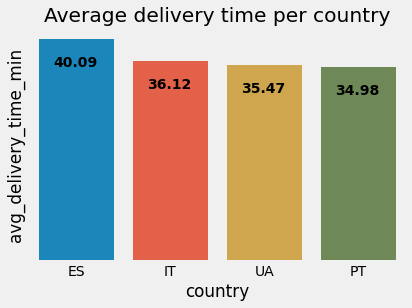

In [16]:
delivery_time_per_country(partners,'avg_delivery_time_min','country','ES','IT','UA','PT','orders_weekly')

Portugal has the best result but difference is not particulary big and vary in 5 mins range from 35 up to 40 mins in Spanish market.

**5. What is the share of orders that integrated partners delivered?**

Here the goal is to calculate the sum of delivered orders by integrated and non-integrated partners and then use pie plot to display proportions.

In [17]:
# # Sum integrated partners and divide by total partners amount
# share_of_integrated = round(partners.loc[partners['is_integrated']=='Yes', 'orders_weekly'].sum() / 
#                                             partners['orders_weekly'].sum()*100, 2)
# # Print result
# print("Share of orders that integrated partners delivered is", share_of_integrated,"%")

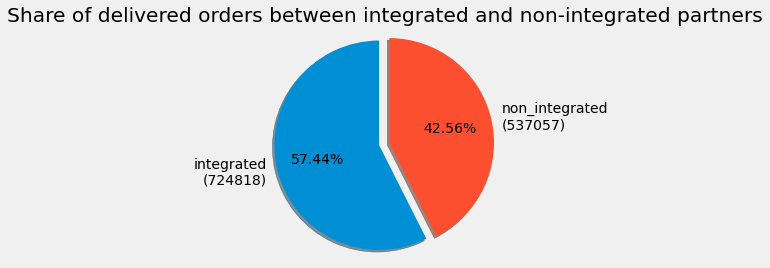

In [18]:
# Calculate sum og orders by integrated and non-integrated partners
size1 = partners.loc[partners['is_integrated']=='Yes', 'orders_weekly'].sum()
size2 = partners.loc[partners['is_integrated']=='No', 'orders_weekly'].sum()

# Set pie chart
labels = ['integrated\n({})'.format(size1), 'non_integrated\n({})'.format(size2)]
sizes = [size1, size2]
explode = (0.1, 0)  # Only "explode" the 1st slice 

# Plot pie chart
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.2f%%',
        shadow=True, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Share of delivered orders between integrated and non-integrated partners")
plt.show()

The number of orders delivered by **integrated** partners is more than **non-itegrated** orders almost in 1.5 times given that total amount of **integrated** parners don't exceed the 25% from all.
That makes curiosity to explore better other dimension in terms of being integrated, meaning to perform bivariate analysis of two categorical variables. In the same time let's test the assumption that there is no difference in being integrated or not using chi-square test for that.

In [19]:
# Function to explore two categorical variables
def BVA_categorical_plot(data, tar, cat):
    
    '''
    Take data and two categorical variables,
    calculates the chi2 significance between the two variables 
    and prints the result with Countplot & CrossTab
    '''
    # Isolate the variables
    data = data[[cat,tar]][:]

    # Form a crosstab
    table = pd.crosstab(data[tar],data[cat],)
    f_obs = np.array([table.iloc[0][:].values,
                        table.iloc[1][:].values])

    # Perform chi2 test
    chi, p, dof, expected = stats.chi2_contingency(f_obs)

    # Check whether results are significant
    if p<0.05:
        sig = True
    else:
        sig = False

    # Plot grouped plot
    fig, (ax_bar, ax_stacked) = plt.subplots(1, 2, figsize=(12,5), constrained_layout=True)
    sns.countplot(x=cat, hue=tar, data=data, ax=ax_bar)
    ax_bar.set_title("P-value = {}\n Difference significant? = {}\n".format(round(p,8),sig), fontsize = 15)
    ax_bar.set_xticklabels(ax_bar.get_xticklabels(),rotation=45)
    
    # Plot percent stacked bar plot
    df_stacked = data.groupby(cat)[tar].value_counts(normalize=True).unstack().round(4)*100
    df_stacked.plot(kind='bar', ylabel='percentage', stacked='True', rot=45, ax=ax_stacked)
    ax_stacked.set_title(str(df_stacked), fontsize = 15)
    int_level = data[cat].value_counts()
    plt.legend(loc='lower center')

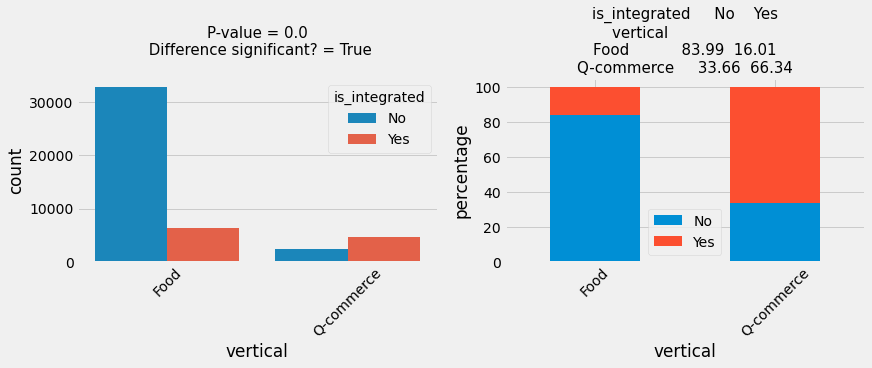

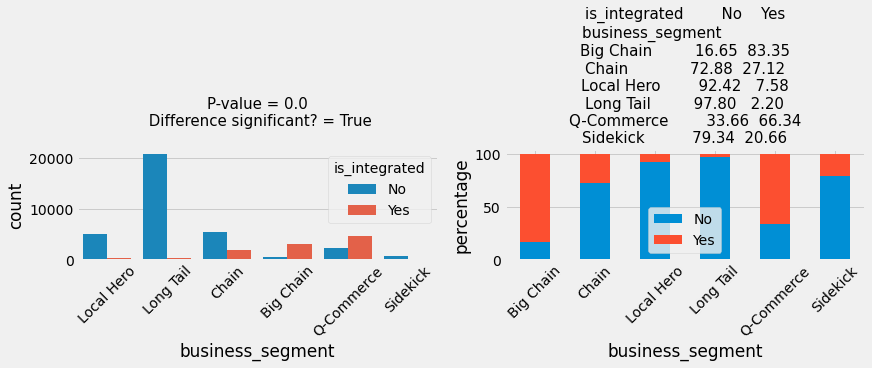

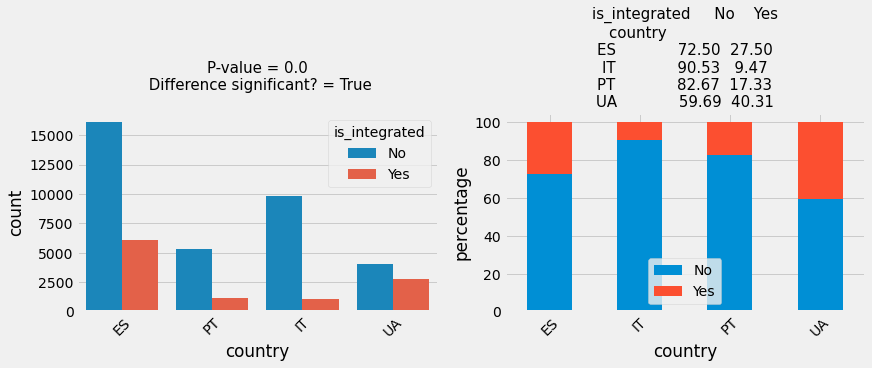

In [20]:
BVA_categorical_plot(categorical, 'is_integrated', 'vertical')
BVA_categorical_plot(categorical, 'is_integrated', 'business_segment')
BVA_categorical_plot(categorical, 'is_integrated', 'country')

Conclusions:

- all differences are significan;
- two-thirds of **Q-commerce** partners are integrated;
- only two *business segments* have integrated majority (**Big Chain** 83.35%, **Q-commerce** 66.34%);
- biggest rate of integrated partners locates in **Ukraine** 40,31%, the second is **Spain** - 27.40%.

**6. What is the distribution of the cost per order? Does it follow any known distribution? Is there anything odd in the distribution?**

There are three common ways to perform univariate analysis:

1. *Summary statistics* – Measures the center and spread of values.

2. *Frequency table* – Describes how often different values occur.

3. *Charts* – Used to visualize the distribution of values.

Let's perform all of them and explore **avg_order_cost** column better.

In [21]:
# Display basic statistic of measure
partners['avg_order_cost'].describe()

count    46208.000000
mean         9.897759
std          5.788162
min          0.000000
25%          6.005454
50%         10.553761
75%         13.158922
max         64.643340
Name: avg_order_cost, dtype: float64

In [22]:
# Group the values into the bins and display frequency table
partners['avg_order_cost'].value_counts(bins=20)

(9.697, 12.929]     14562
(12.929, 16.161]     7511
(6.464, 9.697]       7151
(-0.0656, 3.232]     6452
(3.232, 6.464]       5653
(16.161, 19.393]     2875
(19.393, 22.625]     1157
(22.625, 25.857]      480
(25.857, 29.09]       188
(29.09, 32.322]        97
(32.322, 35.554]       38
(35.554, 38.786]       15
(38.786, 42.018]       12
(42.018, 45.25]         6
(45.25, 48.483]         4
(61.411, 64.643]        3
(48.483, 51.715]        2
(51.715, 54.947]        2
(54.947, 58.179]        0
(58.179, 61.411]        0
Name: avg_order_cost, dtype: int64

mean = 9.9
median = 10.55
mode = 0.0
range = (0.0, 64.64, 64.64)
std_dev = 5.79
skew = 0.26
kurtosis = 1.49


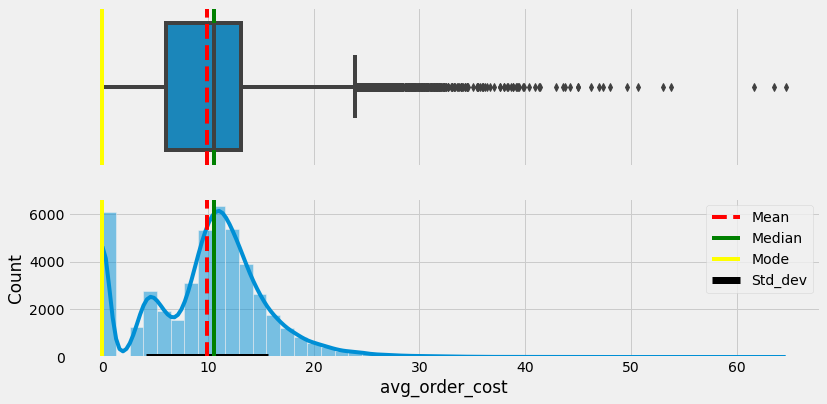

In [23]:
# Set subplots
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(12, 6))

# Summary statistic calculation
mini=partners['avg_order_cost'].min()
maxi=partners['avg_order_cost'].max()
mean=partners['avg_order_cost'].mean()
median=partners['avg_order_cost'].median()
mode=partners['avg_order_cost'].mode().values[0]
rang=partners['avg_order_cost'].max()-partners['avg_order_cost'].min()
st_dev=partners['avg_order_cost'].std()
skew=partners['avg_order_cost'].skew()
kurt=partners['avg_order_cost'].kurtosis()
points = mean-st_dev, mean+st_dev

# Set boxplot
sns.boxplot(data=partners, x='avg_order_cost',ax=ax_box)
ax_box.axvline(mean, color='red', linestyle='--')
ax_box.axvline(median, color='green', linestyle='-')
ax_box.axvline(mode, color='yellow', linestyle='-')
ax_box.set(xlabel='')

# Set histogram
sns.histplot(data=partners, x='avg_order_cost', bins=50, ax=ax_hist, kde=True)
ax_hist.axvline(mean, color='red', linestyle='--', label="Mean")
ax_hist.axvline(median, color='green', linestyle='-', label="Median")
ax_hist.axvline(mode, color='yellow', linestyle='-', label="Mode")
ax_hist.hlines(0, points[0], points[1], linewidth=7, color='black', linestyle='-', label="Std_dev")
ax_hist.legend()

# Prin results
print('mean = {}\nmedian = {}\nmode = {}\nrange = {}\nstd_dev = {}\nskew = {}\nkurtosis = {}'.format(round(mean,2),
                                                                                                round(median,2),
                                                                                                round(mode,2),  
                                                                                                (round(mini,2),round(maxi,2),round(rang,2)),
                                                                                                round(st_dev,2),
                                                                                                round(skew,2),
                                                                                                round(kurt,2)
                                                                                                ))
plt.show()

Summary of **avg_order_cost**:
- value that has the highest frequency is 0 (around 6000 instancies), it means many orders costed nothing to theirs customers, probably they were part of promo actions, free gifts etc.;
- skewness +0.26 says **avg_order_cost** is negligibly biased towards increasing, but common rule if the skewness is between -0.5 and 0.5, the data are fairly symmetrical as what we can consider;
- kurtosis 1.49: extreme values and outliers are very likely to be present in avg_order_cost, that what we can clearly see  on boxplot graph (roughly above 24-25);
- most popular orders have cost around 9-13 with median 10.55;
- std_dev 5.79: low standard deviation indicates that values are clustered close to the mean, which is 9.9.

**7. What is the number of orders compared to connected time? Is there a correlation between the two?**

There are two common ways to perform bivariate analysis for numeric variables:

1. *Scatterplots*

2. *Correlation Coefficients*

Let's do both of them and explore relation between all metrics and then more detailed **orders_weekly** vs **connected_hours**.

During this task it's very important pay attention to presence of outliers in dataset since they can drastically effect on the result.

In [24]:
# Select only numeric columns from dataset (aka metrics)
numerical = partners.drop('partner_id', axis=1).select_dtypes(include='number')

# Calculate carrelation with presence of outliers
round(numerical['orders_weekly'].corr(numerical['connected_hours']),2)

0.2

Usually the strength of the association: **0-0.19** is regarded as *very weak*, **0.2-0.39** as *weak*, **0.40-0.59** as *moderate*, **0.6-0.79** as *strong* and **0.8-1** as *very strong* correlation.

Let's review all dependencies higher than **0.19**.

In order to have different perspectives on the correlation of the independent variables, we will be plotting the heatmaps using three methods of calculating the correlation.

- Pearson Correlation
- Kendal's Tau
- Spearman Correlation

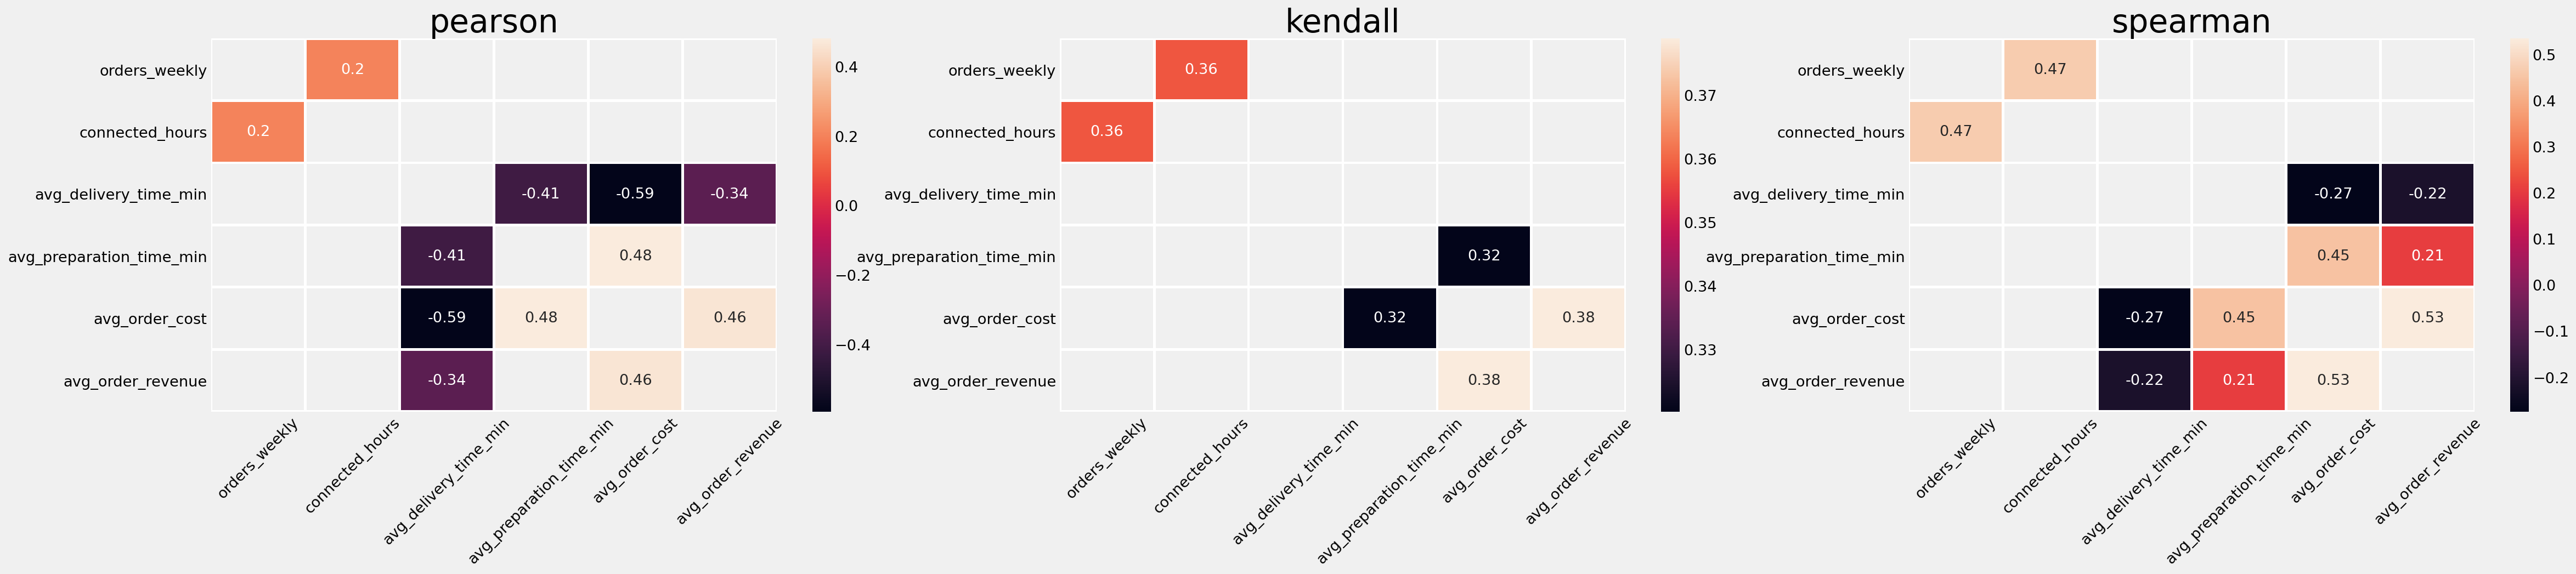

In [25]:
# plotting heatmap usill all methods for all transaction variables
plt.figure(figsize=(36,6), dpi=140)
for j,i in enumerate(['pearson','kendall','spearman']):
    plt.subplot(1,3,j+1)
    correlation = numerical.corr(method=i)
    corrmat = correlation[((correlation>=0.2)|(correlation<=-0.2))&(correlation!=1)]
    sns.heatmap(
        corrmat,
        annot=True,
        linewidth = 2)        
#         cmap='RdBu_r') 
#          
#         vmin=-1, vmax=1)
    plt.xticks(rotation=45)
    plt.title(i, fontsize=30)
    plt.plot()

Now let's review observed columns for outliers using interquartile range method.

In [26]:
# Create custom function to define limits
def outlier_threshold(df, col_name, q1_perc=0.01, q3_perc=0.99):
    """
    Given DataFrame, column name, q1_percentage and q3_percentage, function calculates low_limit and up_limit
    """
    
    quartile1 = df[col_name].quantile(q1_perc)
    quartile3 = df[col_name].quantile(q3_perc)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5*interquantile_range
    low_limit = quartile1 - 1.5*interquantile_range
    return up_limit, low_limit

# Create custom function to detect outliers
def check_outliers(df, col_name):
    low_limit, up_limit = outlier_threshold(df, col_name)
    if df[(df[col_name] > up_limit) | (df[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [27]:
# Print results
print("Outliers in 'orders_weekly' column is : {}".format(check_outliers(partners, 'orders_weekly')))
print("Outliers in 'connected_hours' column is : {}".format(check_outliers(partners, 'connected_hours')))

Outliers in 'orders_weekly' column is : True
Outliers in 'connected_hours' column is : True


Next step is to explore outliers in all metrics, they can drastically effect on the correlation cofficient and further observation. Draw **boxplots** for the observations, two for each measure: one with outliers and one without (to aviod  outliers influence use technique quantile based flooring and capping).

In [28]:
# Function to set up boxplot with outliers or without them
def UVA_outlier(data, var_group, include_outlier = True):
    
    '''
    Univariate_Analysis_outlier:
    takes a group of variables (INTEGER and FLOAT) and plot/print boplot and descriptives
    Runs a loop: calculate all the descriptives of i(th) variable and plot/print it 

    data : dataframe used to plot
    var_group : {list} type Group of Continuous variables
    include_outlier : {bool} whether to include outliers or not, default = True
    '''

    size = len(var_group)
    plt.figure(figsize = (7*size,4), dpi = 100)
  
    # Iterate each variable
    for j,i in enumerate(var_group):
    
        # Calculate descriptives of variable
        quant25 = data[i].quantile(0.25)
        quant75 = data[i].quantile(0.75)
        IQR = quant75 - quant25
        med = data[i].median()
        whis_low = quant25-(1.5*IQR)
        whis_high = quant75+(1.5*IQR)

        # Calculate number of outliers
        outlier_high = len(data[i][data[i]>whis_high])
        outlier_low = len(data[i][data[i]<whis_low])

        if include_outlier == True:
            # Plot the variable with all information
            plt.subplot(1,size,j+1)
            sns.boxplot(data[i], orient="v")
            plt.ylabel('{}'.format(i))
            plt.title('With Outliers\nIQR = {}; Median = {} \n 2nd,3rd  quartile = {};\n Outlier (low/high) = {} \n'.format(
                                                                                                   round(IQR,2),
                                                                                                   round(med,2),
                                                                                                   (round(quant25,2),round(quant75,2)),
                                                                                                   (outlier_low,outlier_high)
                                                                                                   ))
      
        else:
            # Replace outliers with max/min whisker
            data2 = data[var_group][:]
            data2[i][data2[i]>whis_high] = whis_high+1
            data2[i][data2[i]<whis_low] = whis_low-1

      
            # Plot without outliers
            plt.subplot(1,size,j+1)
            sns.boxplot(data2[i], orient="v")
            plt.ylabel('{}'.format(i))
            plt.title('Without Outliers\nIQR = {}; Median = {} \n 2nd,3rd  quartile = {};\n Outlier (low/high) = {} \n'.format(
                                                                                                   round(IQR,2),
                                                                                                   round(med,2),
                                                                                                   (round(quant25,2),round(quant75,2)),
                                                                                                   (outlier_low,outlier_high)
                                                                                                   ))

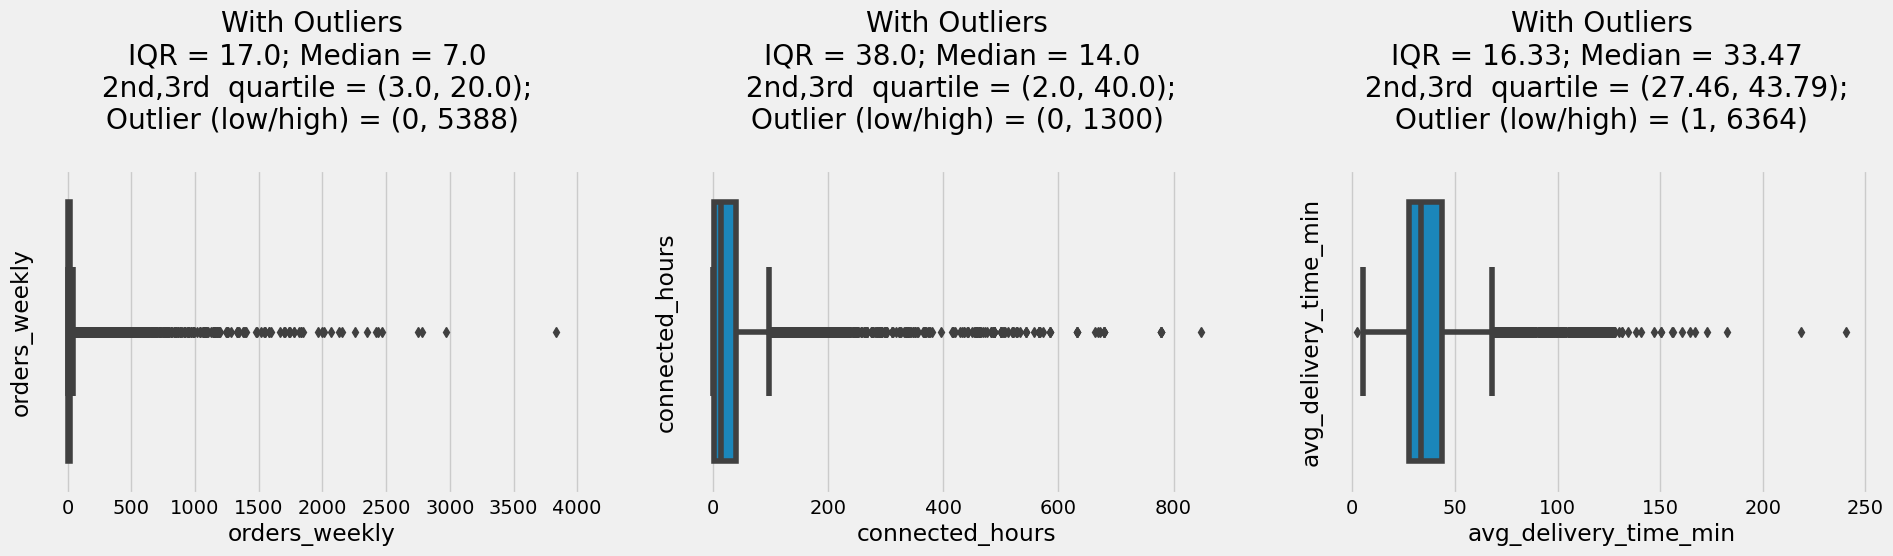

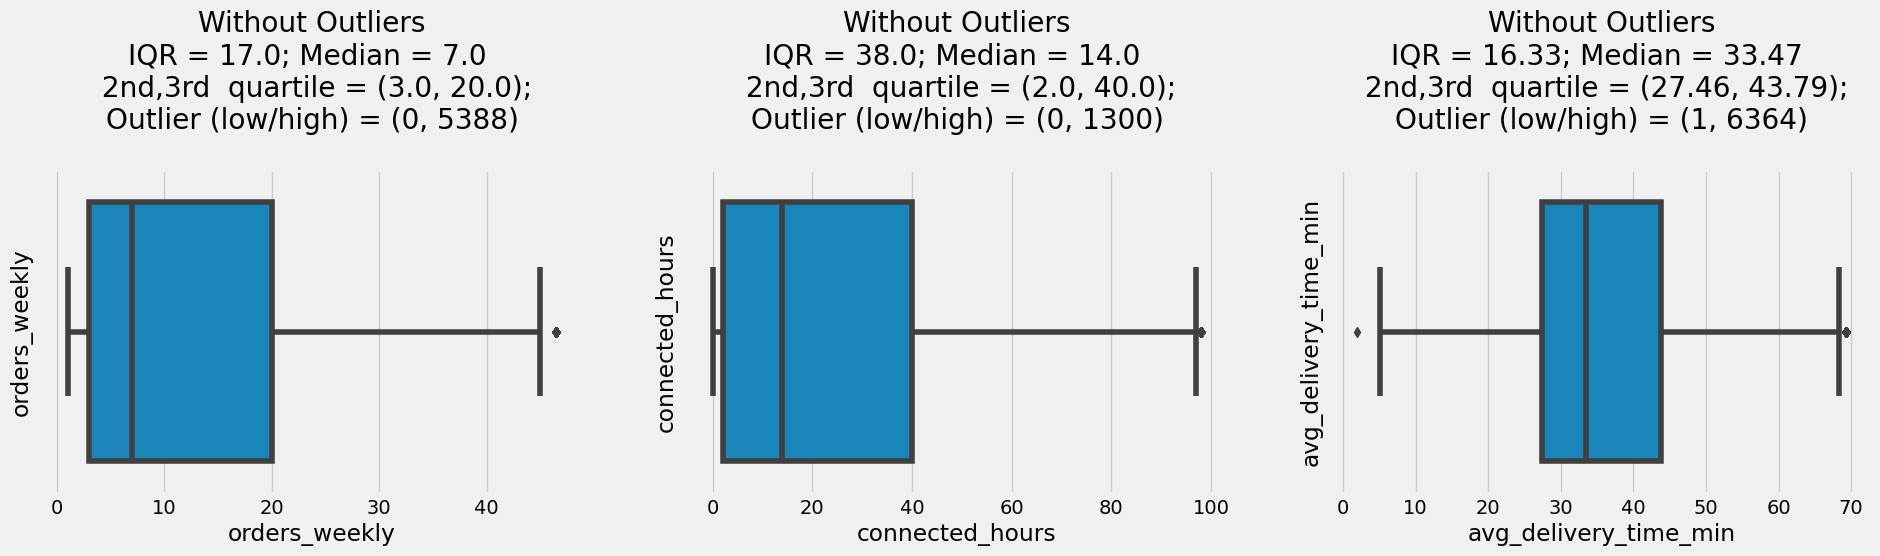

In [29]:
UVA_outlier(numerical, numerical.columns[:3], include_outlier = True)
UVA_outlier(numerical, numerical.columns[:3], include_outlier = False)

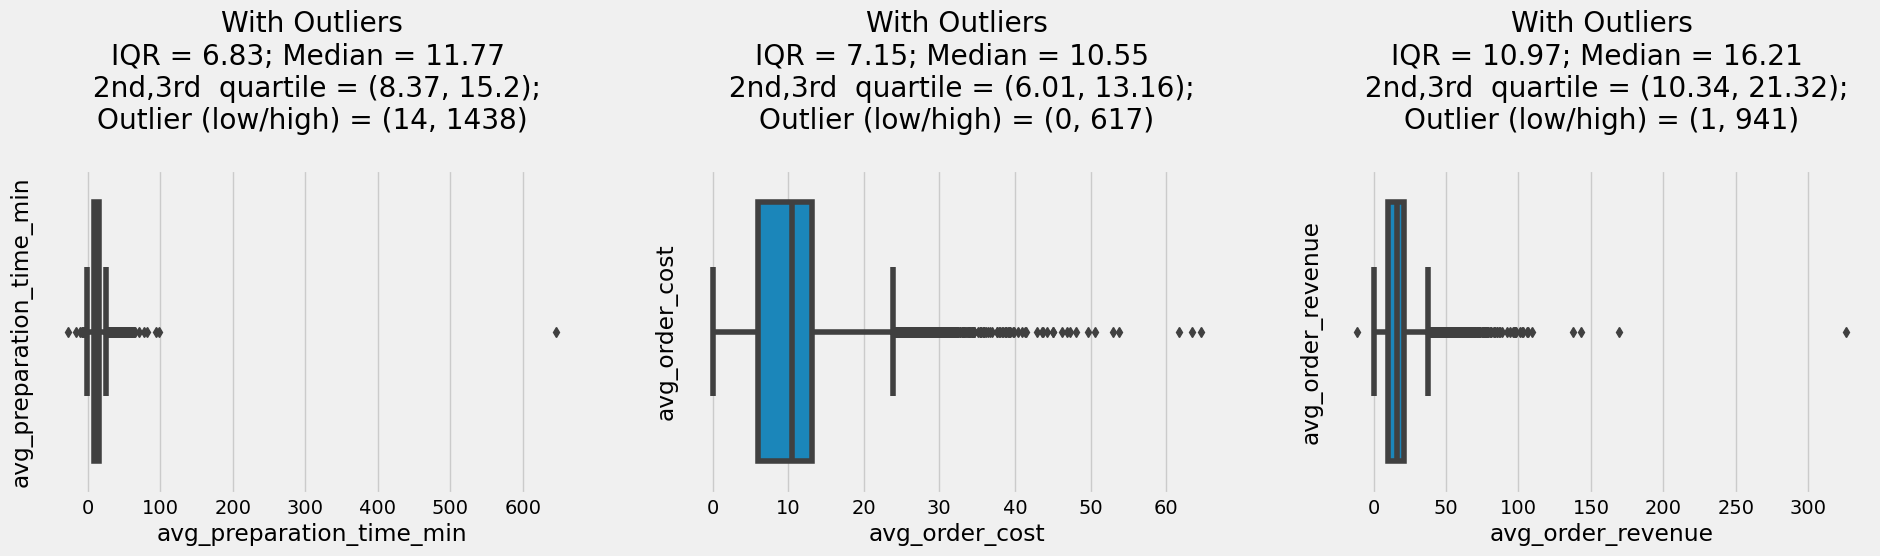

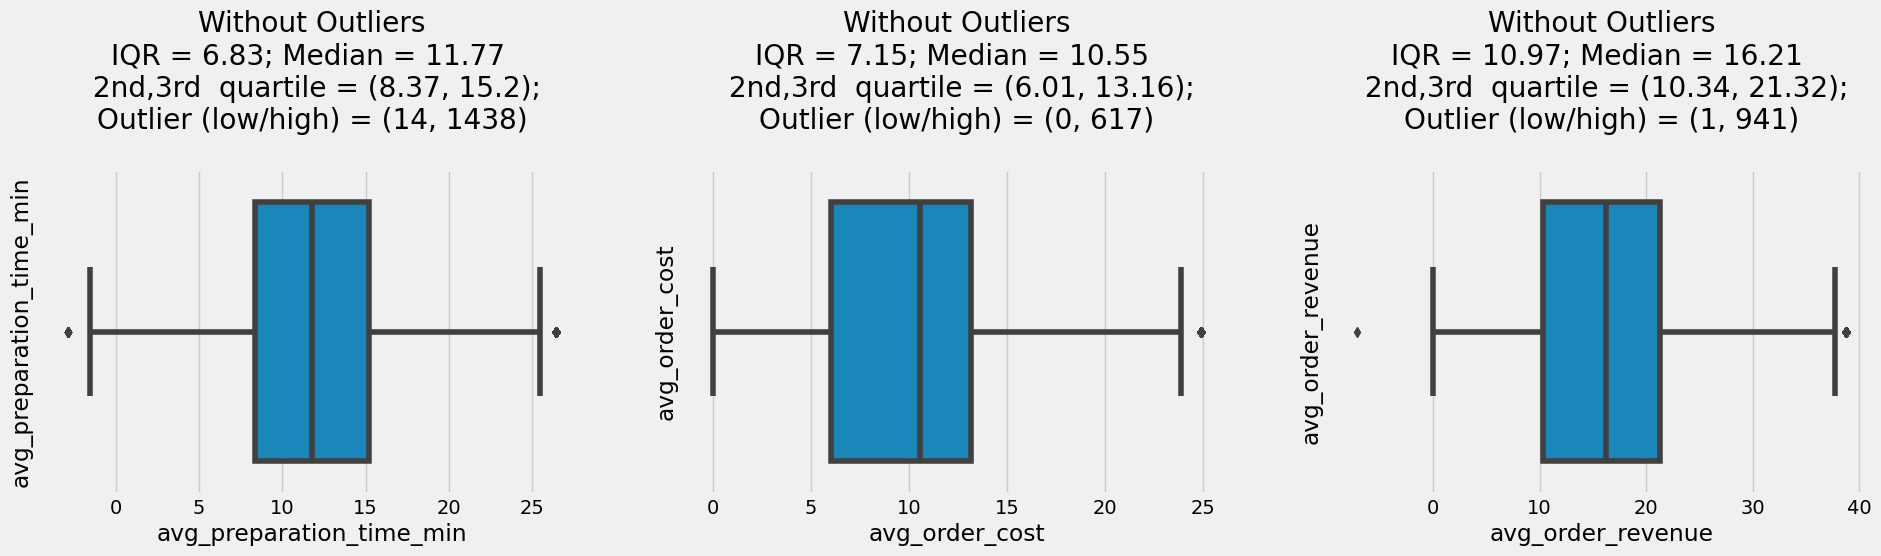

In [30]:
UVA_outlier(numerical, numerical.columns[3:], include_outlier = True)
UVA_outlier(numerical, numerical.columns[3:], include_outlier = False)

Inferences:

- all the metrics have huge amount of outliers;
- most of distribution tend to have positive skewness because of effect of outliers;
- **avg_order_revenue**, **avg_preparation_time_min** and **avg_delivery_time_min** have negative outliers, in case of **avg_order_revenue** it's probably caused by the fact that expenses for some product delivery exceed the cost of product and company doesn't earn in that cases, as for **avg_preparation_time** and **avg_delivery_time_min** having negative numbers looks wierd, maybe these are cases of inconsistent data entry, needs to be explored;
- one work around the skewness and nullify outliers influence is **Log transformation**, let's proceed toward with that technique. 

[]

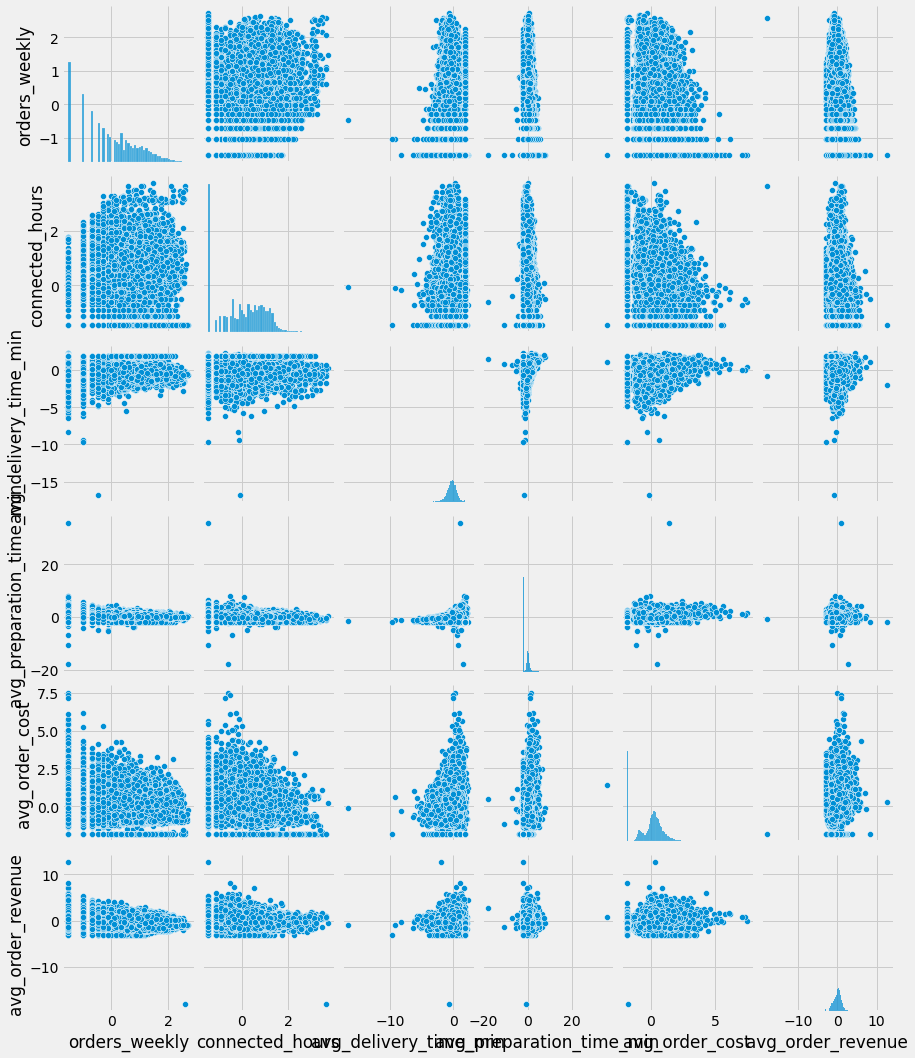

In [31]:
# Apply logorithm tranformation on selected variables
transformer = PowerTransformer()
trans_array = transformer.fit_transform(numerical)
transformed = pd.DataFrame(trans_array,
              index=numerical.index,
              columns=numerical.columns)

# Set pairplot
sns.pairplot(
    data=transformed, 
    aspect=.85)
sns.set_context(rc={"axes.labelsize":8})
plt.plot()

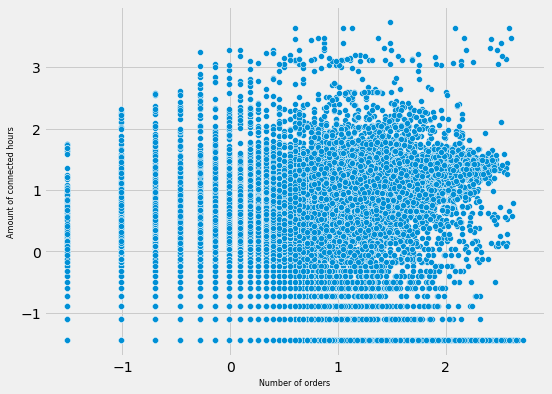

In [32]:
# Set scatterplot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='orders_weekly', y='connected_hours', data=transformed)
plt.xlabel('Number of orders')
plt.ylabel('Amount of connected hours')
plt.show()

After transforming the variables with log method at the first glance we can see on the **Scatterplot** the presence of some covariance probably weak to moderate. Let's build new **Heatmap** (using classic Pearson correlation cofficient) to see exact numbers.

Correlation between number of orders and connected time is: 0.42




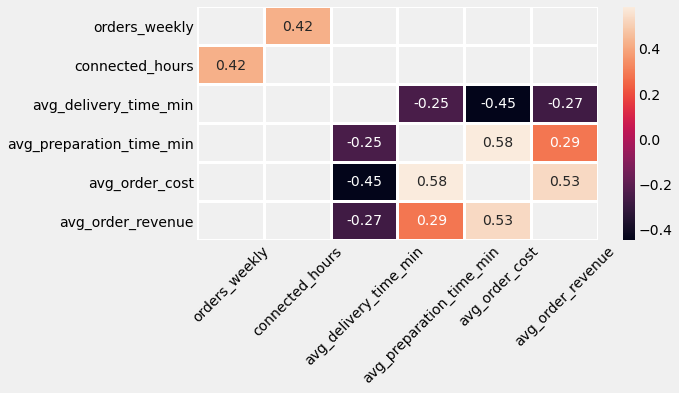

In [59]:
# Set correlation matrix
correlation = transformed.corr()
corrmat = correlation[((correlation>0.2)|(correlation<-0.2))&(correlation!=1)] # Filter the dependencies over 0.2
plt.figure(figsize=(8,4))

sns.heatmap(
    corrmat,        
#     cmap='RdBu_r', 
    annot=True, 
    linewidth = 2)
#     vmin=-1, vmax=1)
plt.xticks(rotation=45)
plt.plot()


# Calculate correlation coficient between two measures
correlation = round(transformed['orders_weekly'].corr(transformed['connected_hours']),2)

# Print result
print("Correlation between number of orders and connected time is:", correlation)
print('\n')

After transformation the gotten result of orders/hours correlation is around 0.42. 
Besides of **Heatmap** that's good to print all correlation coficient in ascending order to have clear picture and identify easily the strongest ones.

In [60]:
# Build correlation table
df_corr = transformed.corr()

#  Creates a mask to remove the diagonal and the upper triangle.
lower_triangle_mask = np.tril(np.ones(df_corr.shape), k=-1).astype("bool")

#  Stack all correlations, after applying the mask
df_corr_stacked = df_corr.where(lower_triangle_mask).stack().sort_values()

#  Showing the lowest and highest correlations in the correlation matrix
print(df_corr_stacked)

avg_order_cost            avg_delivery_time_min      -0.446611
avg_order_revenue         avg_delivery_time_min      -0.270158
avg_preparation_time_min  avg_delivery_time_min      -0.249100
avg_delivery_time_min     connected_hours            -0.084759
avg_order_cost            orders_weekly              -0.046805
avg_delivery_time_min     orders_weekly              -0.033441
avg_preparation_time_min  connected_hours            -0.003429
avg_order_revenue         orders_weekly              -0.000552
avg_preparation_time_min  orders_weekly               0.019894
avg_order_cost            connected_hours             0.046845
avg_order_revenue         connected_hours             0.141540
                          avg_preparation_time_min    0.289657
connected_hours           orders_weekly               0.423930
avg_order_revenue         avg_order_cost              0.533816
avg_order_cost            avg_preparation_time_min    0.584755
dtype: float64


**Conclusion:** Looking at the distribution on the scatterplot possible to see that there is not strong correlation between two measures. And with using of 'corr' Pandas method correlation is caculated around 0.42, that could be considered as moderate.
Performed analysis displays that the strongest two correlations are positive and between **avg_order_cost** vs **avg_preparation_time** and **avg_order_revenue** vs **avg_order_cost**. The first case could be due to the fact the most complicated and respectively expensive orders take longer time to be completed. The second case seems to be obvious most expensive products can generate more income for company.

**8. What are the differences in the metrics for Food vs Q-commerce?**

This task require to perform bivariate analysis *numeric variables vs categorical one*.
Let's build several plots to understand data relation better and make some conclusions.
I am going to use *bar, density and box plots* to explore distribution of metrics in terms of **vertical** dimension.

Moreover, in this section I will work with hypothesis testing. 
The null hypothesis is defined like *there is no significant difference between Food and Q-commerce partners in terms of metrics*.

I will do the hypothesis testing during the plotting of graphs.
Three functions for this taks:

- function for 2 sample Z-Test;
- function for 2 sample T-Test;
- function for plotting which uses the above mentioned two functions.

Both Z-test and T-test are presented here to qualify that they perform similarly.

In [35]:
# Create custom function to perform 2-sampled Z-Test
def TwoSampZ(X1, X2, sigma1, sigma2, N1, N2):
    
    '''
    Takes mean, standard deviation, and number of observations and returns p-value calculated for 2-sampled Z-Test
    '''
    ovr_sigma = np.sqrt(sigma1**2/N1 + sigma2**2/N2)
    z = (X1 - X2)/ovr_sigma
    pval = 2*(1 - stats.norm.cdf(np.abs(z)))
    
    return pval

# Create custom function to perform 2-sampled T-Test
def TwoSampT(X1, X2, sd1, sd2, n1, n2):
    '''
    Takes mean, standard deviation, and number of observations and returns p-value calculated for 2-sample T-Test
    '''
    ovr_sd = np.sqrt(sd1**2/n1 + sd2**2/n2)
    t = (X1 - X2)/ovr_sd
    df = n1+n2-2
    pval = 2*(1 - stats.t.cdf(np.abs(t),df))
    
    return pval

# Create custom function to plot data
def Bivariate_cont_cat(data, cont, cat, category1, category2):
    
    # Create 2 samples
    x1 = data[cont][data[cat]==category1][:]
    x2 = data[cont][data[cat]==category2][:]
  
    # Calculate descriptives
    n1, n2 = x1.shape[0], x2.shape[0]
    m1, m2 = x1.mean(), x2.mean()
    std1, std2 = x1.std(), x2.mean()

    # Calculate p-values
    t_p_val = TwoSampT(m1, m2, std1, std2, n1, n2)
    z_p_val = TwoSampZ(m1, m2, std1, std2, n1, n2)

    # Create pivot table
    table = pd.pivot_table(data=data, values=cont, columns=cat, aggfunc = np.mean)

    # Plotting
    plt.figure(figsize = (20,4), dpi=140)

    # Set barplot
    plt.subplot(1,3,1)
    sns.barplot([str(category1),str(category2)], [m1, m2])
    plt.ylabel('mean {}'.format(cont))
    plt.xlabel(cat)
    plt.title('t-test p-value = {} \n z-test p-value = {}\n {}\n'.format(t_p_val,
                                                                    z_p_val,
                                                                    table))
    
    # Set densityplot, category-wise distribution
    plt.subplot(1,3,2)
    sns.kdeplot(x1, shade= True, color='blue', label = 'Food')
    sns.kdeplot(x2, shade= False, color='green', label = 'Q-commerce', linewidth = 1)
    plt.title('categorical distribution')

    # Set boxplot
    plt.subplot(1,3,3)
    sns.boxplot(x=cat, y=cont, data=data)
    plt.title('categorical boxplot')

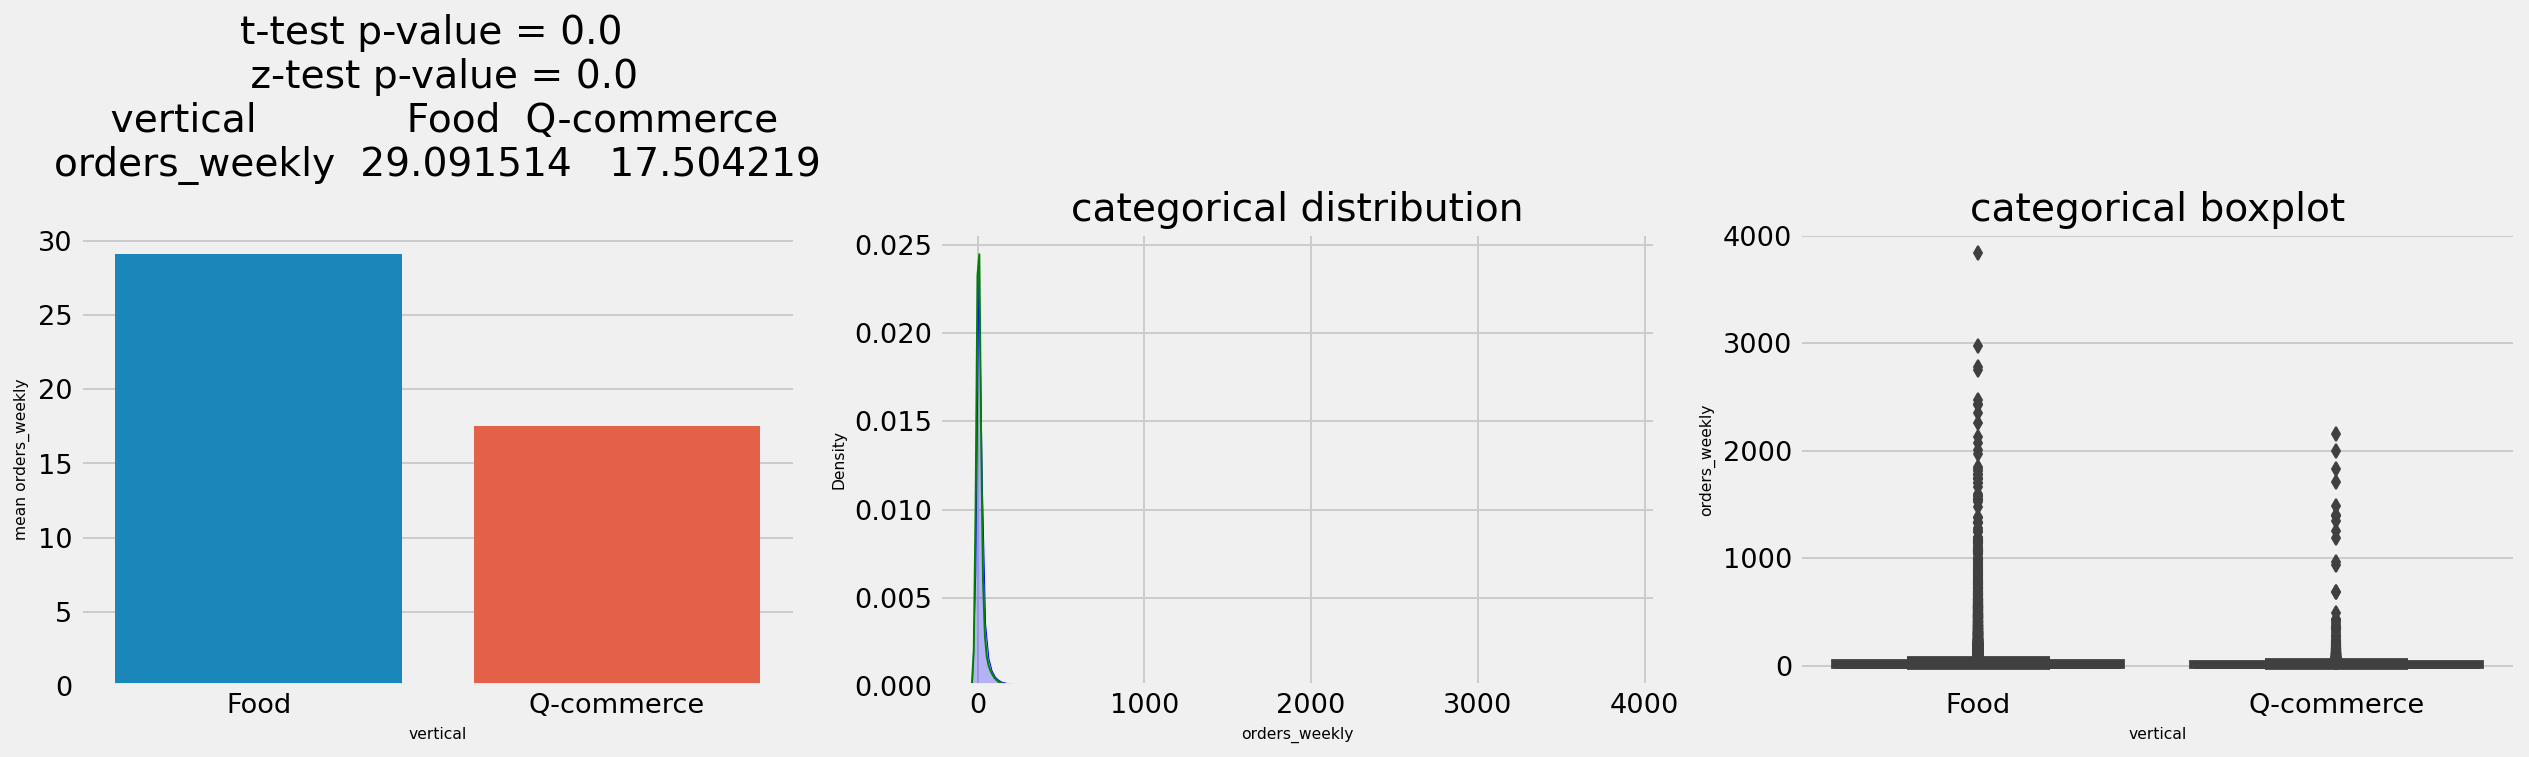

In [36]:
Bivariate_cont_cat(partners, 'orders_weekly', 'vertical', 'Food', 'Q-commerce')

**Inferences:**

- *Food* partners have more orders in average;
- p-value is < 0.05, null hypothesis is rejected, results are significant;
- densityplot shows very similar distribution;
- there are outliers on boxplot that effects on total results.

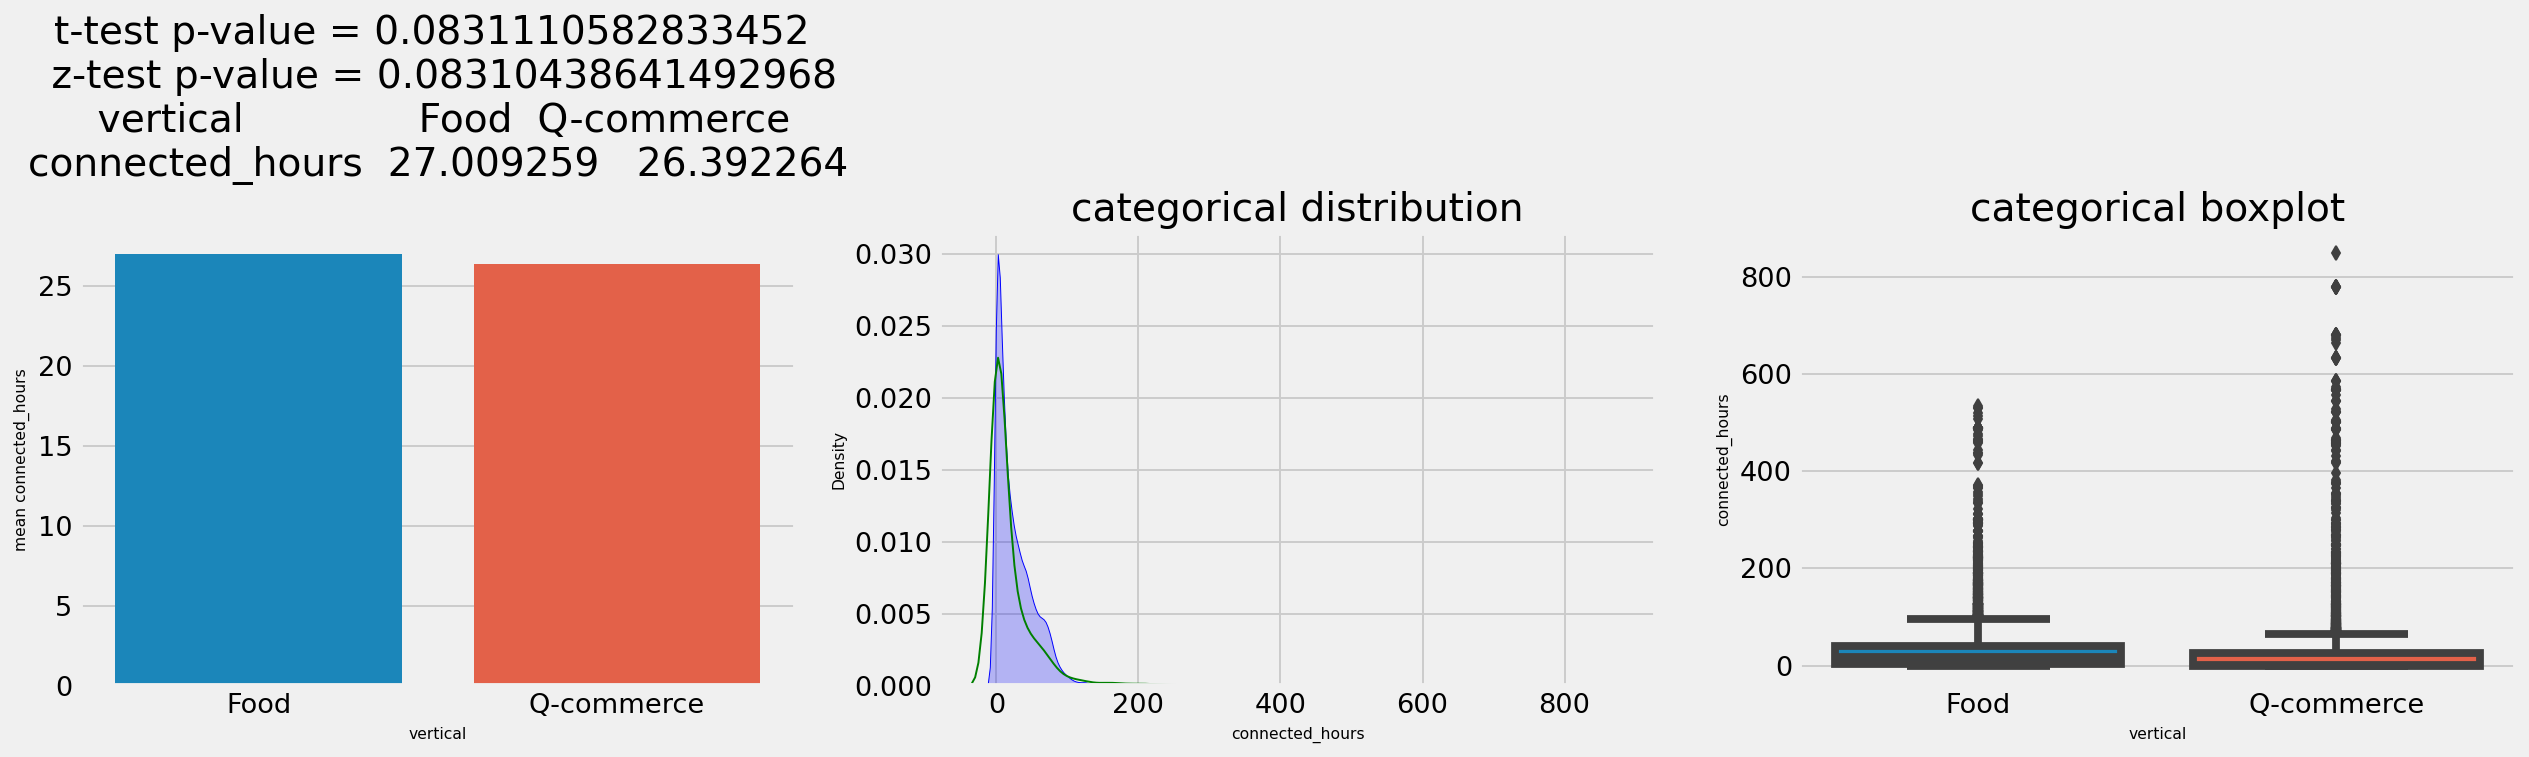

In [37]:
Bivariate_cont_cat(partners, 'connected_hours', 'vertical', 'Food', 'Q-commerce')

**Inferences:**

- two samples have more or less similar distribution;
- means of both subset are pretty close to each other, results are significant (p>0.05);
- Q-commerce subset has outliers with higher hours amount.

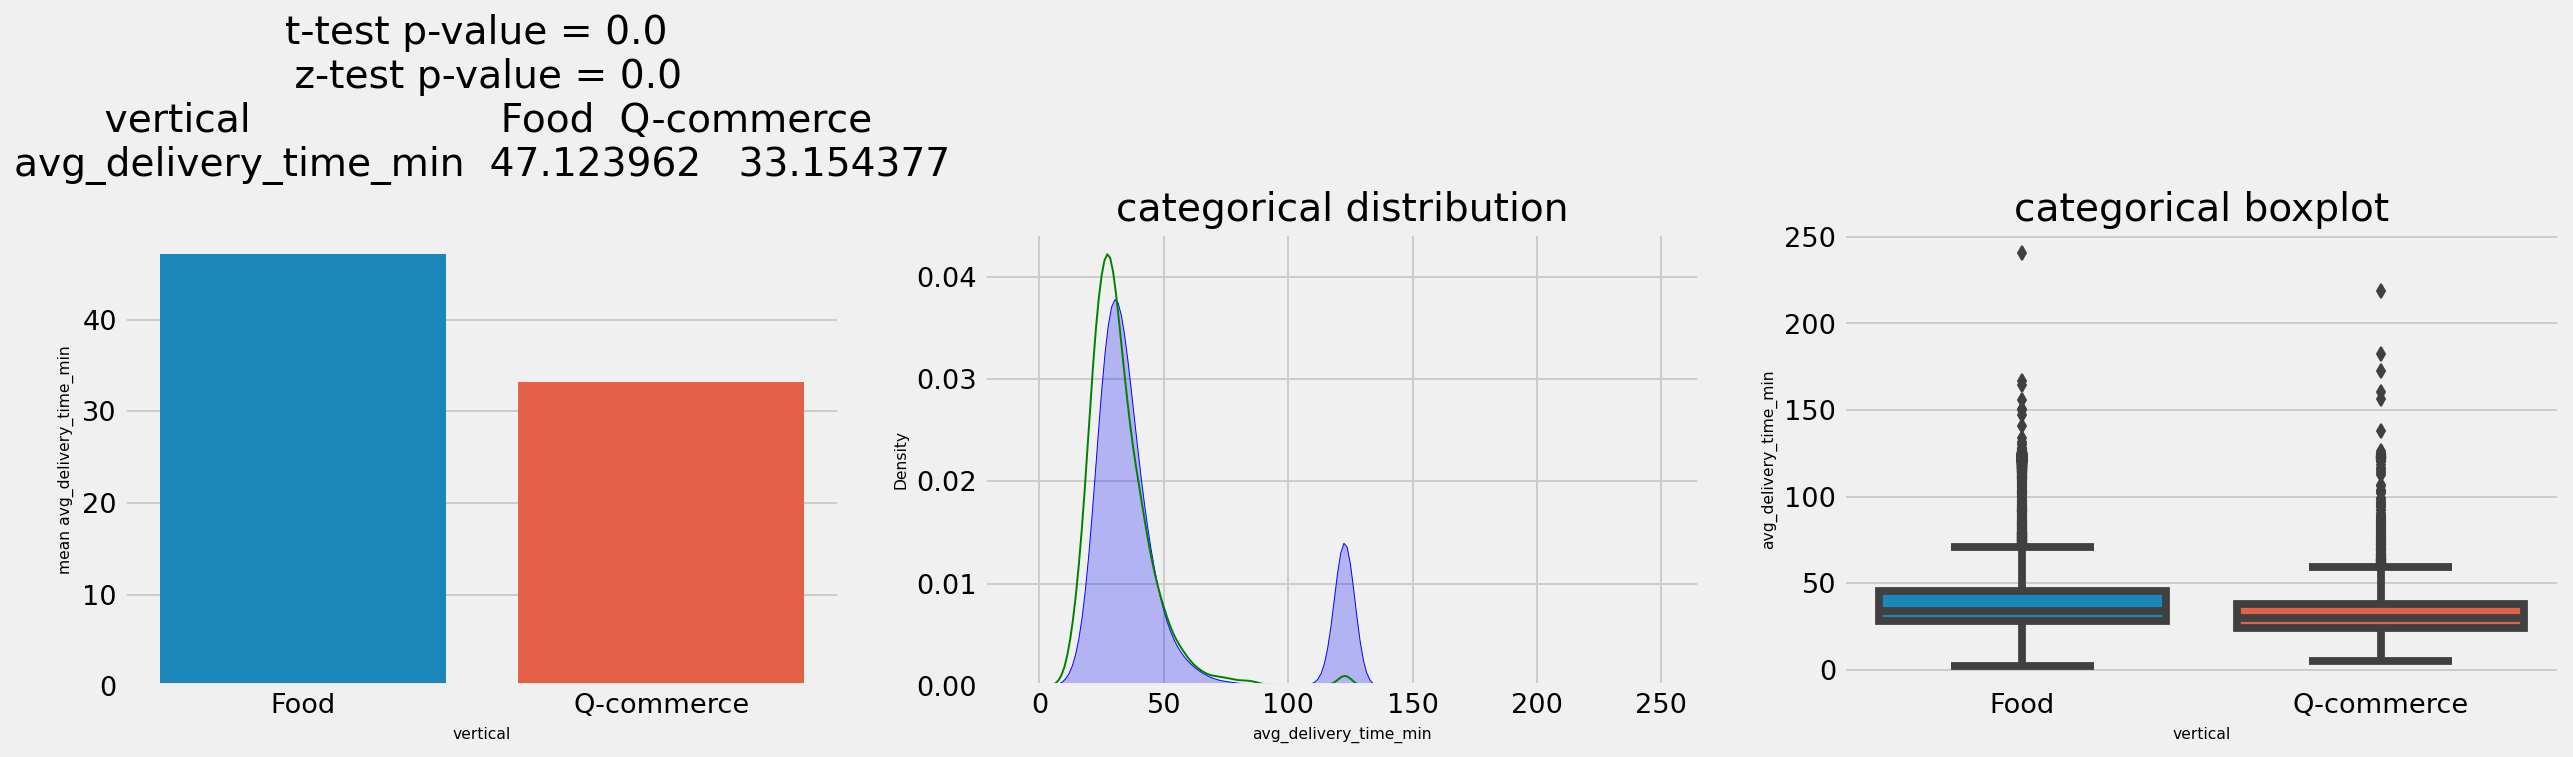

In [38]:
Bivariate_cont_cat(partners, 'avg_delivery_time_min', 'vertical', 'Food', 'Q-commerce')

**Inferences:**

- *Food* partners have significantly higher average delivery time;
- plots show there is much bigger number of partners in *Food* category who has average time between of 100 and 150 mins;
- p-value is < 0.05: reject null hypothesis;
- both sample have outliers that can impact on results.

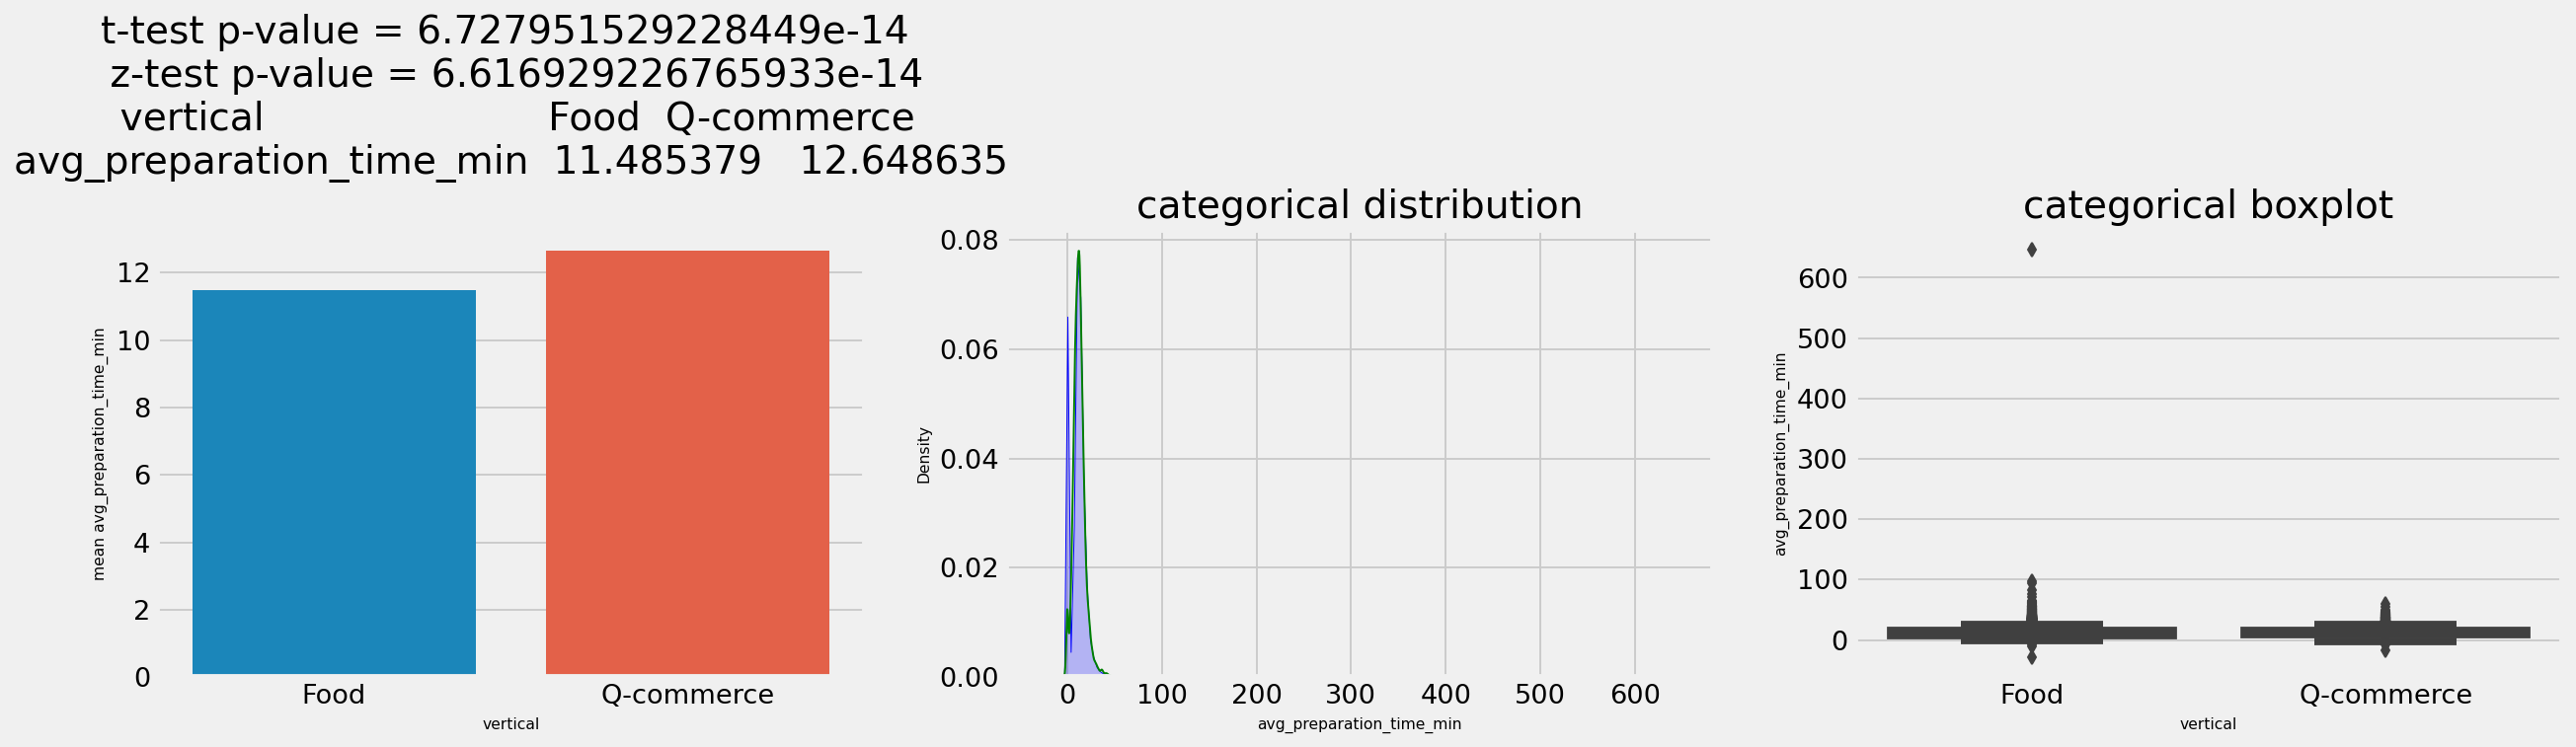

In [39]:
Bivariate_cont_cat(partners, 'avg_preparation_time_min', 'vertical', 'Food', 'Q-commerce')

**Inferences:**

- *Q-commerce* partners have slightly higher average preparation time;
- samples are significant different, p_value < 0.05;
- both distributions show many partners have close to 0 average preparation time;
- *Food* subset has one outlier who reflects a lot on mean result.

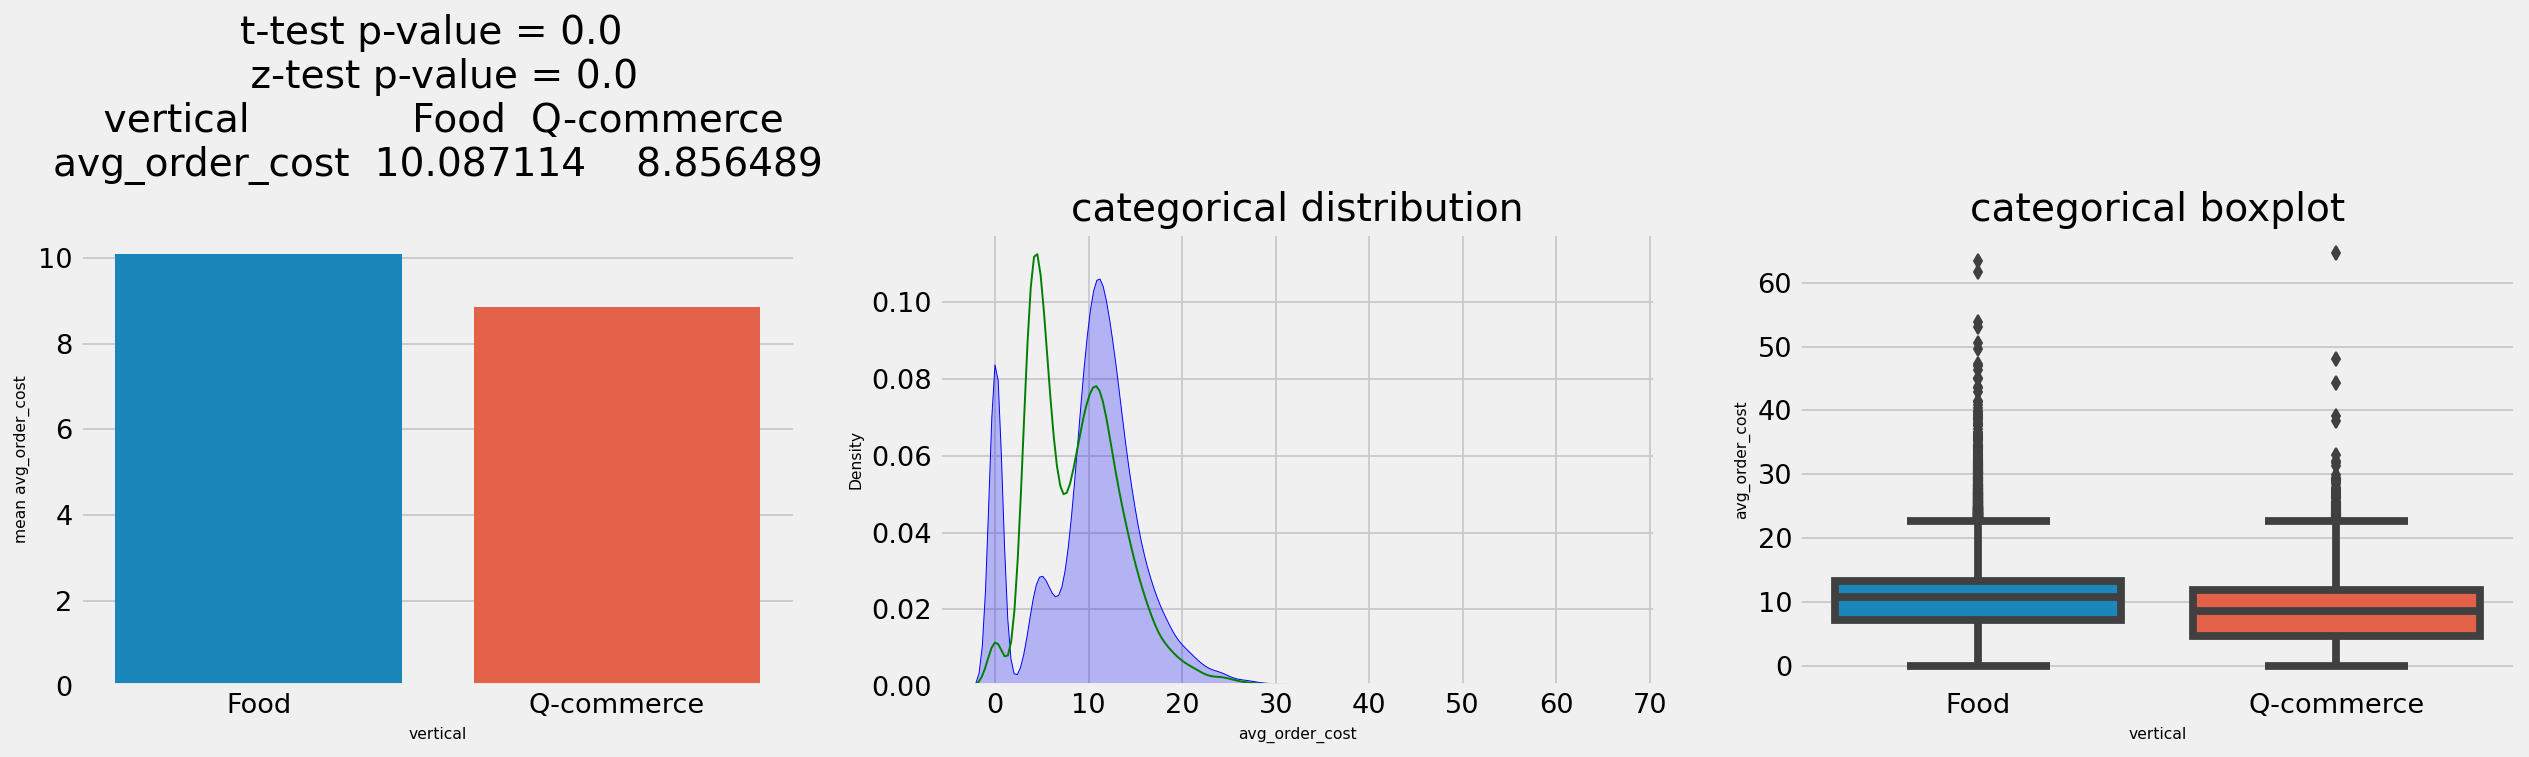

In [40]:
Bivariate_cont_cat(partners, 'avg_order_cost', 'vertical', 'Food', 'Q-commerce')

**Inferences:**

- *Food* partners have higher average order cost;
- results are significant, p_value < 0.05, reject null hypothesis;
- distributions vary, many *Food* partners have 0 cost orders, it can mean they perform promo actions, free gifts etc.;
- both subsets have many outliers.

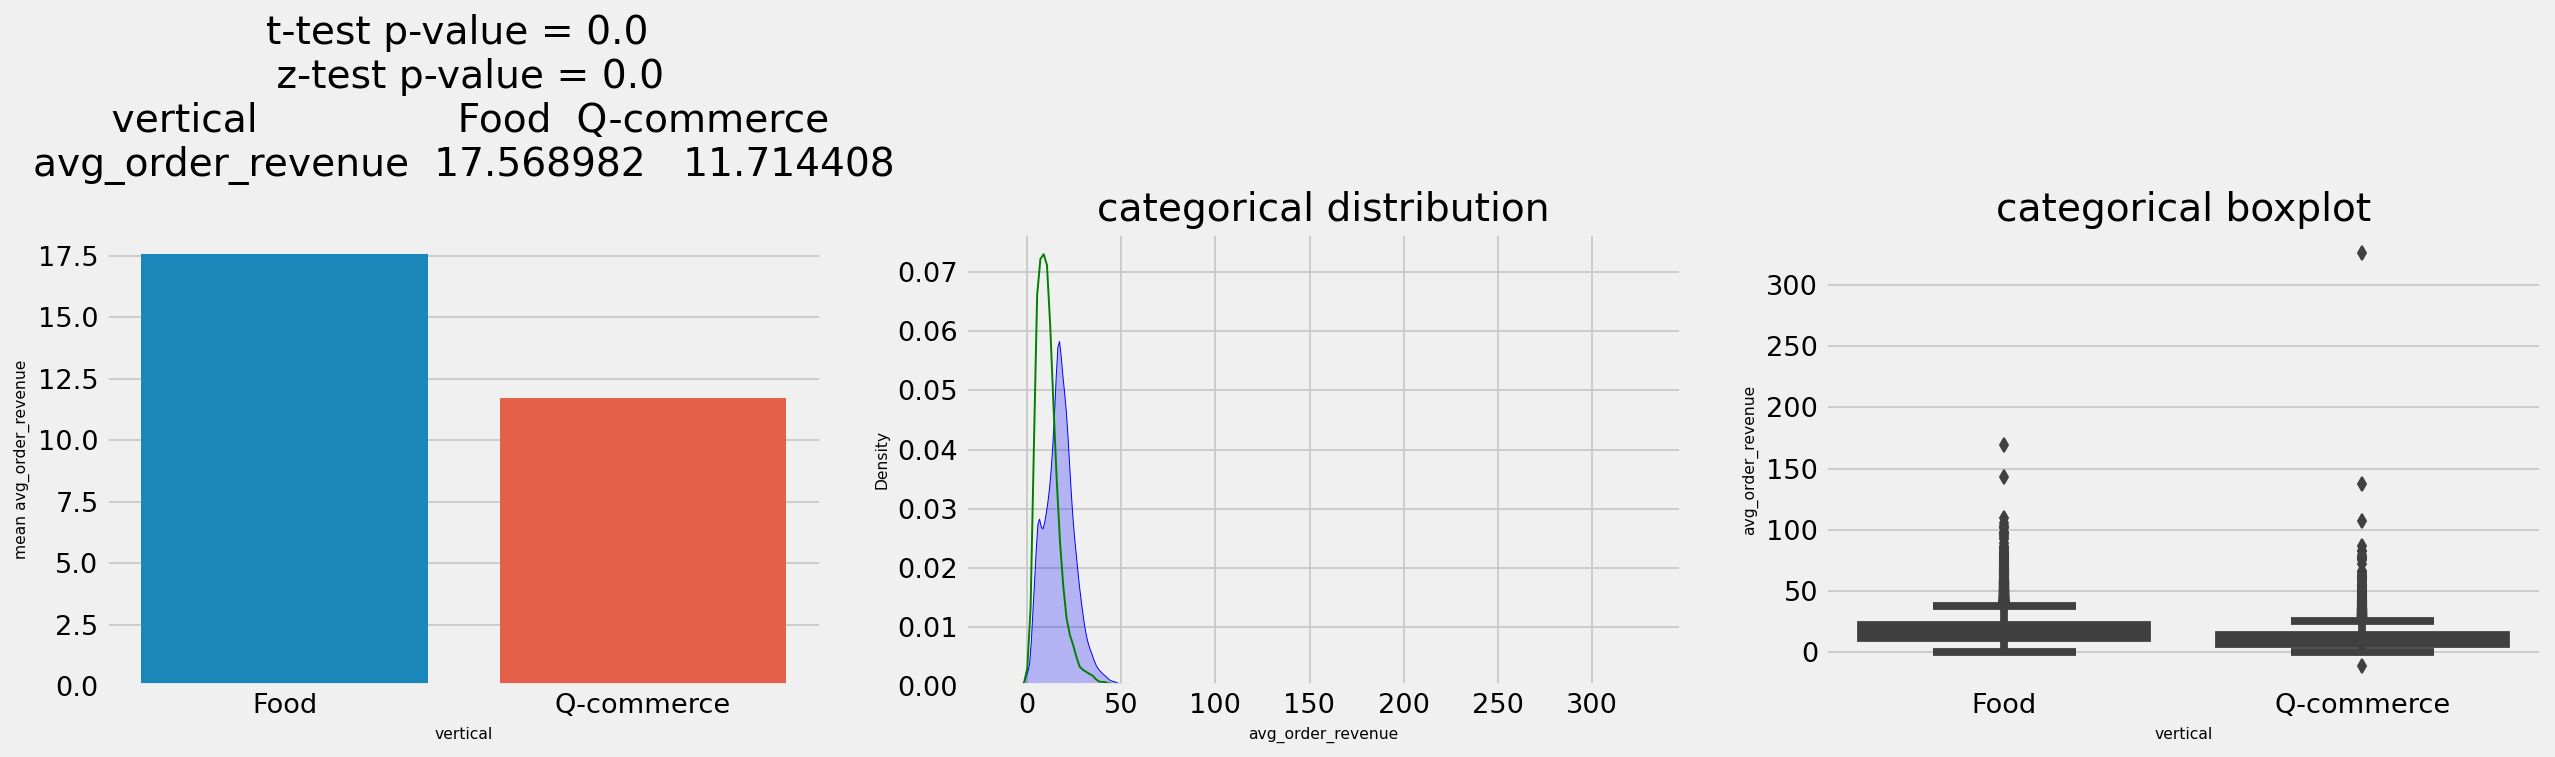

In [41]:
Bivariate_cont_cat(partners, 'avg_order_revenue', 'vertical', 'Food', 'Q-commerce')

**Inferences:**

- *Food* partners have significantly higher average order revenue, p_value < 0.05;
- *Q-commerce* subset has one outlier who reflets a lot on average result.

I'm wondering to explore split of Food and Q-commerce partners in each country to see popularity of Q-commerce.

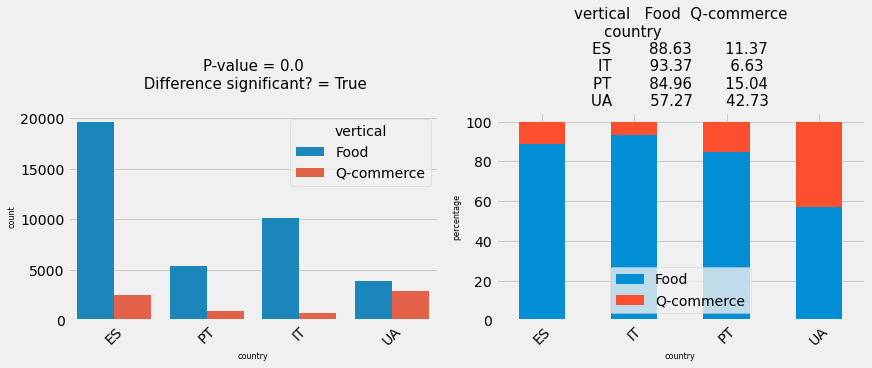

In [42]:
# Define above function for bivariate analysis of two dimensions
BVA_categorical_plot(categorical, 'vertical', 'country')

Highest popularity of Q-commerce is in Ukraine. That's sign people are interested in quick delivery and don't want to wait a lot for the order.

**9. Among all the possible combinations of dimensions (segments), which one has the highest number of partners?**

The decision is to group by all dimensions and apply 'size' method to get number of rows (since each row is record for one unique partner we are getting number of partners) for every possible combination of dimensions. Then sort result in descending order and select the top one.

In [43]:
# Groupby all dimension and get size of each combination
number_of_partners = partners.groupby(['vertical','business_segment','is_integrated','country'], 
                                              as_index=False).size()
# Rename column in more appropriate way
number_of_partners.rename(columns={'size':'number_of_partners'}, inplace=True)

# Print result
print("Combination of dimensions with the highest number of partners:")
print('\n', "-"*70,'\n') 
print(number_of_partners.sort_values('number_of_partners', ascending=False).head(12))

Combination of dimensions with the highest number of partners:

 ---------------------------------------------------------------------- 

      vertical business_segment is_integrated country  number_of_partners
24        Food        Long Tail            No      ES               10297
25        Food        Long Tail            No      IT                5983
26        Food        Long Tail            No      PT                2644
45  Q-commerce       Q-Commerce           Yes      UA                2303
4         Food        Big Chain           Yes      ES                2161
16        Food       Local Hero            No      ES                2054
8         Food            Chain            No      ES                2003
27        Food        Long Tail            No      UA                1881
42  Q-commerce       Q-Commerce           Yes      ES                1652
17        Food       Local Hero            No      IT                1612
9         Food            Chain            No   

In Spain, Italy and Portugal the biggest group of partners belongs to Long Tail business_segment, Food vertical and non-integrated type. Similarity can be parcially explained common behavioural patterns in South Europe Mediterranean cultures.
In Ukraine the biggest segment is Q-commerce partners who are integrated.

The biggest combination Spain/Long Tail/Food/Non-integrated is almost quarter of all partners in the dataset. 

**10. Summarize your findings in an executive summary.**






The dataset contains 46208 active partners.

Majority is represented by *Spanish* market (22183), that is double more than second lagest *Italian* (10840) and even triple bigger in comparison with *Ukraine* and *Portugal* (6808, 6377 accordingly). 

Most of partners belongs to *Long Tail* business segment (21273) that is three times ahead of the second in a row *Chain* segment (7529).

80% of all orders in dataset has been delivered by 21.37 % of partners. This observation confirms *Pareto principle* that roughly 80% of consequences come from 20% of causes.

The smallest average delivery time is in Portugues market (34.98%). That could make assumption the couriers job is performed more eefectively than in others regions. Things to explore further the reasons behind successful delivery process.

57.44 % of all orders has been delivered by integrated partners. Thing to investigate further is correlation between *"is_integrated"* status and list of metrics to get better understanding of influence when status is True.

The detailed observation of *avg_order_cost* metric displays most frequent value is 0, it could mean many partners (*Food* category mostly) run promotions or grant some orders as gifts.

The correlation between *orders_weekly* and *connected_hours* is 36.81 %, it can be considered as moderate. 
Quick review of all metrics shows the strongest dependencies (positive correlation) between *avg_preperation_time* and *avg_order_cost*, the reason of it could be in the fact that most expensive orders are also the most difficult to prepare and take more time to be done.

Section with comparison of two categories *Food* vs *Q-commerce* shows all metrics have many outliers. And even that Food partners have in average higher results in most of metrics (some could be considered as positive *avg_order_revenue*, some as negative *avg_delivered _time*) those results are under impact of outliers.

Quick observation of metric distributions shows they vary in ranges and for futher purposes to apply machine learning distanced-based (clustering) or gradient descend based (regressions) algorythms, it's necessary to perform feature scaling technique (like MinMax Scaler for example). 

# Task 2

**1. Which combination of dimensions (segments) has the highest business value in your opinion for Glovo and why?**

To solve this taks aggregate all measures by every possible combination of dimensions, create additional measures and explore them to find highest values in dataset. 

In [44]:
# Custom function to calculate weighted average
wm = lambda x: np.average(x, weights=partners.loc[x.index, "orders_weekly"])

# Aggregate all measures by each dimensions combination
combos = partners.groupby(['country','business_segment','vertical','is_integrated'], as_index=False).agg(
                                                                    {
                                                                       'partner_id': pd.Series.nunique,
                                                                       'orders_weekly':'sum', 
                                                                       'connected_hours':'sum', 
                                                                       'avg_delivery_time_min':wm, 
                                                                       'avg_preparation_time_min':wm,
                                                                       'avg_order_cost':wm,
                                                                       'avg_order_revenue':wm,
                                                                       }
                                                                   )
    
# Rename column in more appropriate way      
combos.rename(columns={'partner_id':'num_partners'}, inplace=True)
combos.head()

,country,business_segment,vertical,is_integrated,num_partners,orders_weekly,connected_hours,avg_delivery_time_min,avg_preparation_time_min,avg_order_cost,avg_order_revenue
0,ES,Big Chain,Food,No,270,9540,13543,33.367876,10.834982,11.251835,15.480613
1,ES,Big Chain,Food,Yes,2161,206255,62760,44.054751,9.186179,10.407087,14.922463
2,ES,Chain,Food,No,2003,52120,64778,35.386156,12.304347,11.882931,20.486766
3,ES,Chain,Food,Yes,1402,76876,62755,36.547239,12.154076,11.420697,18.736465
4,ES,Local Hero,Food,No,2054,70717,66643,38.410203,11.150664,10.871773,21.697229


In [45]:
# Generate new additional measures of effectiveness
combos['avg_order_profit'] = combos['avg_order_revenue'] - combos['avg_order_cost']
combos['total_profit'] = (combos['orders_weekly']*combos['avg_order_profit']).round(0).astype('int')

# Sort dataset by chosen metrics to display top ranked
top_three_profit = combos.sort_values('total_profit', ascending=False).head(3)
top_three_avg_profit = combos.sort_values('avg_order_profit', ascending=False).head(3)
top_three_orders = combos.sort_values('orders_weekly', ascending=False).head(3)

I decided to extend the task and performed observation of combinations with top three results in several chosen metrics.

The first metric is **total profit** that is the most important for every business to exist and have further progress.
The most ranked combinations in this group belong to Spanish market and have *Food* category in 'vertical' dimension. The best one is integrated and belongs to *Big Chain* business segment. There is huge amount of orders here, it means this segment is very active and generates a lot of interactions with clients. Then suggestion for this combination would be increasing number of partners in the same segment.

In [46]:
top_three_profit

,country,business_segment,vertical,is_integrated,num_partners,orders_weekly,connected_hours,avg_delivery_time_min,avg_preparation_time_min,avg_order_cost,avg_order_revenue,avg_order_profit,total_profit
1,ES,Big Chain,Food,Yes,2161,206255,62760,44.054751,9.186179,10.407087,14.922463,4.515376,931319
6,ES,Long Tail,Food,No,10297,92731,221660,45.709507,10.637117,10.571533,19.256016,8.684483,805321
4,ES,Local Hero,Food,No,2054,70717,66643,38.410203,11.150664,10.871773,21.697229,10.825456,765544


Next metrics for observation is **average profit per order** tells us combination with best earning potential on each order. And the champions in that measure are partners from Italian market who is integrated, belongs to *Food* category in 'vertical' dimension, and have *Long Tail* business segment. Unfortunately they are few, 19 only, so suggestion here is the same: firstly try to increase the number of partners. 

But if explore two next most ranked combinations with bigger number of partners it can be defined they are pretty similar, both in Spanish market, *Food* vertical, *Local Hero* business segment and only difference in integrated status. For both combinations one more suggestion could be promotion of those partners to increase number of orders with highest average profit.

In [47]:
top_three_avg_profit

,country,business_segment,vertical,is_integrated,num_partners,orders_weekly,connected_hours,avg_delivery_time_min,avg_preparation_time_min,avg_order_cost,avg_order_revenue,avg_order_profit,total_profit
19,IT,Long Tail,Food,Yes,19,140,185,29.378810,10.888588,13.594227,29.070969,15.476742,2167
4,ES,Local Hero,Food,No,2054,70717,66643,38.410203,11.150664,10.871773,21.697229,10.825456,765544
5,ES,Local Hero,Food,Yes,295,12769,8928,37.534670,11.356433,10.865673,21.674037,10.808364,138012


Third chosen metric is **total number of orders** and results here show that in three countries: Spain, Ukrain and Italy, the biggest order numbers are generated by integrated partners from *Big Chain* business segment in *Food* category by 'vertical'. The best one combo is also the winner of first observed group **(total profit)**, so suggestion here stays the same, look for the partners in the same segment since they have a lot of customers, but also it can be expected to get even more orders with special promo actions. As it was mentioned above those partners are very popular and customers tend to search for their goods. 

In [48]:
top_three_orders

,country,business_segment,vertical,is_integrated,num_partners,orders_weekly,connected_hours,avg_delivery_time_min,avg_preparation_time_min,avg_order_cost,avg_order_revenue,avg_order_profit,total_profit
1,ES,Big Chain,Food,Yes,2161,206255,62760,44.054751,9.186179,10.407087,14.922463,4.515376,931319
35,UA,Big Chain,Food,Yes,88,106256,3215,27.596975,12.143697,5.322507,7.769756,2.447249,260035
13,IT,Big Chain,Food,Yes,493,102013,24636,28.014042,12.859083,13.618353,16.783116,3.164763,322847


**2. We want to run an experiment in Spain (ES). Create two groups of partners that behave similarly in terms of metrics. 
Make sure all types of partners are represented.**

To perform the task apply unsupervise machine learning technique for hehavioral segmentation and identify clusters of data objects in a dataset.
Then take one cluster, check the presence of all possible types of partners, and split it onto two groups: control and test, for further purposes in experiment. 

In [49]:
# Select Spanish partners only
spain = partners[partners['country']=="ES"].reset_index(drop=True)

# Select columns with metrics 
spain_metrics = spain[['orders_weekly','connected_hours','avg_delivery_time_min','avg_preparation_time_min',
                       'avg_order_cost','avg_order_revenue']]

I am going to use K-means clustering algorythm that is example of distance-based one. It needs to consider all features on an even playing field. That means the values for all features must be transformed to the same scale. PowerTransformer is a log based transforming method from most popular machine learning library Scikit-Learn can solve this taks for dataset with presence of outliers.

In [51]:
# Scale metric columns
transformer = PowerTransformer()
spain_transformed = transformer.fit_transform(spain_metrics)

# Print result
print(spain_transformed)

[[-1.14607538  0.1426785  -1.33763464  0.41204385 -0.79348624 -0.53863563]
 [ 0.73885854 -1.51136451 -0.12760048  1.08043542  0.55312103  0.43447224]
 [ 0.79626443  0.66845256 -0.1027236   0.08175757  0.86130979  0.87142328]
 ...
 [-1.6193361  -1.51136451 -0.95538723  0.7460874   1.07098326  4.89795038]
 [-1.6193361  -0.72536189 -1.4279884  -0.28813831  0.30897852 -0.44109689]
 [-1.6193361  -0.4452055  -0.07203703 -0.33078809  0.68089601  0.03640924]]


Next step is to define number of cluster we need to split our dataset on. 
There are two most common methods are used to evaluate the appropriate number of clusters:

- *the elbow method*
- *the silhouette coefficient*

These are often used as complementary evaluation techniques rather than one being preferred over the other. 
To perform the **elbow method**, need to run several models, increment k (number of clusters) with each iteration, and record the sum of the squared error (evaluation metric).

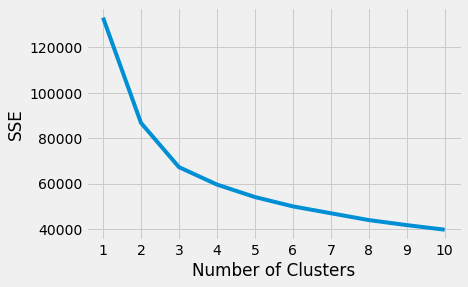

In [52]:
# Set parameters of the model
kmeans_kwargs = {

    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
 }

# Holds the SSE values for each k
sse = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(spain_transformed)
    sse.append(kmeans.inertia_)
    
# Plot result    
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

There is a spot where the SSE curve starts to bend known as the elbow point. The x-value of this point is a reasonable trade-off between error and number of clusters. The given elbow is located at x=3.

Determining the elbow point in the SSE curve isn’t always straightforward, then Python package **kneed** can be used to identify the elbow point programmatically.

In [53]:
kl = KneeLocator(
     range(1, 11), sse, curve="convex", direction="decreasing"
 )

kl.elbow

3

The **silhouette coefficient** is a measure of cluster cohesion and separation. It quantifies how well a data point fits into its assigned cluster based on two factors:

- *how close the data point is to other points in the cluster*
- *how far away the data point is from points in other clusters*

Silhouette coefficient values range between -1 and 1. Larger numbers indicate that samples are closer to their clusters than they are to other clusters.

Loop through values of k again. This time, instead of computing SSE, compute the silhouette coefficient.

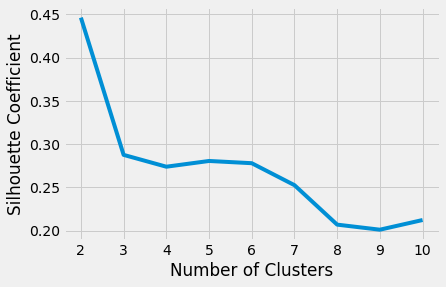

In [54]:
# Holds the silhouette coefficients for each k
silhouette_coefficients = []

# Start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(spain_transformed)
    score = silhouette_score(spain_transformed, kmeans.labels_)
    silhouette_coefficients.append(score)

# Plot result
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

All three applied method to determine correct number of clusters shows that 3 is a right choice.

In [55]:
# Run the algorythm
kmeans = KMeans(n_clusters=3, **kmeans_kwargs)

# Predict clusters
clusters = kmeans.fit_predict(spain_transformed)

# Save cluster labels and number of istances
unique, counts = np.unique(clusters, return_counts=True)

# Print result
print(dict(zip(unique, counts)))

# Assign the labels to each partner
spain["label"] = clusters

{0: 9762, 1: 3432, 2: 8989}


I am going to check the all possible combinations of dimensions to be sure having all types of partners for both clusters.

In [56]:
# Print names of all possible segments
print(spain['business_segment'].unique())
print('\n')

# Print number of all combinations and types of partners for cluster 0
print(spain[spain['label']==0].groupby(['vertical', 'business_segment', 'is_integrated',
       'country'], as_index=False).size())
print('-'*50,'\n')

# Print number of all combinations and types of partners for cluster 1
print(spain[spain['label']==1].groupby(['vertical', 'business_segment', 'is_integrated',
       'country'], as_index=False).size())
print('-'*50,'\n')

# Print number of all combinations and types of partners for cluster 2
print(spain[spain['label']==2].groupby(['vertical', 'business_segment', 'is_integrated',
       'country'], as_index=False).size())

['Local Hero' 'Chain' 'Long Tail' 'Q-Commerce' 'Big Chain' 'Sidekick']


      vertical business_segment is_integrated country  size
0         Food        Big Chain            No      ES    48
1         Food        Big Chain           Yes      ES   145
2         Food            Chain            No      ES   651
3         Food            Chain           Yes      ES   342
4         Food       Local Hero            No      ES   543
5         Food       Local Hero           Yes      ES    89
6         Food        Long Tail            No      ES  5636
7         Food        Long Tail           Yes      ES   187
8         Food         Sidekick            No      ES   257
9         Food         Sidekick           Yes      ES    97
10  Q-commerce       Q-Commerce            No      ES   580
11  Q-commerce       Q-Commerce           Yes      ES  1187
-------------------------------------------------- 

      vertical business_segment is_integrated country  size
0         Food        Big Chain   

As it's possible to see all types are presented in new dataset, that is ready to be splitted for experiment.
To perform selection and assigning the *control* & *test* groups use numpy funtion **random.binominal**, that draws samples from a binomial distribution.

In [57]:
# Count shape of distribution
first_cluster = spain[spain['label']==0].copy()
second_cluster = spain[spain['label']==1].copy()
third_cluster = spain[spain['label']==2].copy()

length0 = first_cluster.shape[0]
length1 = second_cluster.shape[0]
length2 = third_cluster.shape[0]

# Apply binominal half by half
first_cluster['label'] = np.random.binomial(1, .5, length0)
second_cluster['label'] = np.random.binomial(1, .5, length1)
third_cluster['label'] = np.random.binomial(1, .5, length2)

# Replace numeric lables with text ones
spain = pd.concat([first_cluster, second_cluster, third_cluster], axis=0, ignore_index=True)
spain['label'] = spain['label'].replace([0,1], ['Control','Test'], regex=True)

# Print percentage of presence
print(spain['label'].value_counts(normalize=True)*100)
print('\n')

# Print subset of dataframe
print(spain.head())

Control    50.340351
Test       49.659649
Name: label, dtype: float64


   partner_id vertical business_segment is_integrated country  orders_weekly  \
0      169385     Food       Local Hero            No      ES              2   
1      247635     Food            Chain           Yes      ES             23   
2      884885     Food       Local Hero           Yes      ES             18   
3     1142860     Food            Chain            No      ES              9   
4     2291935     Food        Long Tail            No      ES             36   

   connected_hours  avg_delivery_time_min  avg_preparation_time_min  \
0               18              21.933333                 13.095000   
1                0              33.005072                 18.019130   
2                0              23.546296                  9.034444   
3                0              32.424074                 13.044444   
4                2              39.110648                 18.034079   

   avg_order_cost  a

In [58]:
# # Set scatterplot
# def plot_scatter(df, x, y):
    
#     plt.figure(figsize=(6, 4))
#     sns.scatterplot(df[x], df[y], data=df)
#     plt.xlabel(x)
#     plt.ylabel(y)
#     plt.title("Correlation is: {}%".format(round(df[x].corr(df[y])*100,2)))
#     plt.show()
    
    
# plot_scatter(transformed, 'avg_order_cost', 'avg_preparation_time_min')
# plot_scatter(transformed, 'total_profit', 'orders_weekly')
# plot_scatter(transformed, 'avg_order_revenue', 'avg_order_cost')
# plot_scatter(transformed, 'avg_order_profit', 'avg_order_revenue')
# plot_scatter(transformed, 'total_profit', 'avg_order_profit')
# plot_scatter(transformed, 'avg_order_cost', 'avg_delivery_time_min')
# plot_scatter(transformed, 'avg_preparation_time_min', 'avg_delivery_time_min')
# plot_scatter(transformed, 'avg_preparation_time_min', 'avg_delivery_time_min')    